# NLP using PySpark

Ubuntu (Linux)/macOS, Jupyter Notebook, Python 3;
Copyright: Xiaoyi (Sherry) Zhu

In [1]:
# import modules

import numpy as np
import seaborn as sns
import pandas as pd
from pandas.compat import StringIO

import re
import csv
import os
import os.path
import string

from contextlib import closing
from bs4 import BeautifulSoup

from requests import get
from requests.exceptions import RequestException

from contextlib import closing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from pprint import pprint
import datetime 
import random
import math
import nltk

import json
import logging
import sqlite3
from sqlite3 import OperationalError

import findspark
#findspark.init('/home/sherry/spark-2.4.0-bin-hadoop2.7')
findspark.init('/anaconda2/lib/python2.7/site-packages/pyspark')
import pyspark
from pyspark import sql
from pyspark.sql import Row
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as F
from pyspark.sql.functions import countDistinct,avg,stddev,mean
from pyspark.sql.functions import format_number,date_format
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import (dayofmonth,hour,dayofyear,month,year,weekofyear)
from pyspark.sql.types import IntegerType
from pyspark_dist_explore import hist
from IPython.display import display, HTML, display_html #useful to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
#from nltk.corpus import stopwords

# set seed
random.seed(121)

# [function] find a specific string/pattern between two expressions

def find_between(s, first, last):
    try:
        start = s.index( first ) + len(first)
        end = s.index(last, start)
        return s[start:end]
    except ValueError:
        return ''

def find_between_r(s, first, last):
    try:
        start = s.rindex(first) + len(first)
        end = s.rindex(last, start)
        return s[start:end]
    except ValueError:
        return ''
    
# [function] define a function to remove special characters but only keep hyphen

def removeSpecial (text):
    """
    This function is defined to remove all special characters but keep hyphens "-".
    """
    lower = text.lower()
    upper = text.upper()
    res = ''
    
    for i in range(len(text)):
        if text[i].isnumeric() or text[i].lower() != text[i].upper() or text[i] == '-' or text[i] == ' ':
            res += text[i]
    return res

# [function] define a function for pre-processing

def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

In [2]:
# read in lyrics dataset & nationality raw field:
tm_dat = pd.read_csv('data/lyrics_final.csv', encoding='ISO-8859-1')
genre_dat = pd.read_csv('data/TEAM_wiki1959-2018_with_genres_cleaned.csv', encoding='ISO-8859-1')
raw_dat = pd.read_csv('data/TEAM_wiki1959-2018.csv', encoding='ISO-8859-1')

genre_dat.sample(20)

,rank,song,artist,year,nationality,country,genres,genres_cleaned
908,9,Mrs. Robinson,Simon &amp; Garfunkel,1968,U.S.,US,'Folk_rock','Rock'
238,39,Little Sister,Elvis Presley,1961,U.S.,US,"'Country_music', 'Rock_and_roll'","'Country', 'Rock'"
2252,53,Together,Tierra,1981,U.S.,US,-,-
394,95,Where Have All the Flowers Gone?,The Kingston Trio,1962,California,US,-,-
5974,75,Sky Walker,Miguel,2018,U.S.[2],US,-,-
2374,75,Gloria,Laura Branigan,1982,U.S.,US,"'Disco', 'Italo_disco', 'Dance_music', 'Pop_mu...","'Electronic', 'Pop'"
4896,97,Better than Me,Hinder,2007,U.S.,US,"'Post-grunge', 'Rock_music'",'Rock'
2845,46,Causing a Commotion,Madonna,1987,U.S.,US,'Dance-pop','Pop'
3475,76,When She Cries,Restless Heart,1993,United States,US,"'Country_rock', 'Soft_rock', 'Country_music'","'Country', 'Rock'"
4060,61,"""If You""",Silk,1999,United States,US,-,-


In [3]:
print("Number of records in raw data, columns=",raw_dat.shape)

('Number of records in raw data, columns=', (6001, 5))


## Pre-processing

In [4]:
# NEED to join the lyrics data to get all info

raw_dat = raw_dat[['nationality']]
genre_dat = genre_dat[['genres_cleaned']]

# join the datasets
frames = [raw_dat, tm_dat, genre_dat]
pdALL = pd.concat(frames, axis=1, join_axes=[raw_dat.index])
pdALL.to_csv('data/All.csv',encoding='ISO-8859-1',index=False)

pdALL.sample(5)

,nationality,artist,rank,song,year,obsnum,url,lyrics,genres_cleaned
2101,U.S.,Blondie,1,Call Me,1980,2102,https://genius.com/blondie-call-me-lyrics,\r\r\r\r\r\r\r\r\n\r\r\r\r\r\r\r\r\n[Intro]?\r...,'Rock'
3359,U.S.,The Heights,59,How Do You Talk to an Angel,1992,3360,https://genius.com/the-heights-how-do-you-talk...,url not retrieved,"'Electronic', 'Rhythm_and_Blues', 'Rock'"
2440,United States,Kenny Rogers,40,We've Got Tonight,1983,2441,https://genius.com/kenny-rogers-weve-got-tonig...,\r\r\r\r\r\r\r\r\n\r\r\r\r\r\r\r\r\nI know it'...,-
1044,U.S.,"Blood, Sweat &amp; Tears",45,You've Made Me So Very Happy,1969,1045,https://genius.com/blood-sweat-amp-tears-youve...,url not retrieved,"'Rhythm_and_Blues', 'Jazz'"
5862,U.S.,Kendrick Lamar,62,DNA,2017,5863,https://genius.com/kendrick-lamar-dna-lyrics,"\r\r\n\r\r\n[Verse 1]\r\r\nI got, I got, I got...",-


## Data Cleaning
Data Preparation Pipeline

In [5]:
pdDF = pdALL

# [new] replace 'United States' with 'U.S.', etc.
pdDF['country'] = pdDF['nationality'].str.strip()
replace_char = ["USA1","USAA","United States","US","U.S.[1]","U.S.[2]","U.S.[3]","U.S","USA",
               "North Carolina US", "North Carolina USA", "New York City","US1","USA1","USA USA"] # ***
pdDF['country'] = pdDF['country'].str.replace('|'.join([re.escape(s) for s in replace_char]), 'U.S.')

replace_char = ["United Kingdom","UK","England"]
pdDF['country'] = pdDF['country'].str.replace('|'.join([re.escape(s) for s in replace_char]), 'U.K.')

# replace states with country
allStates = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

pdDF['country'] = pdDF['country'].str.replace('|'.join([re.escape(s) for s in allStates]), 'U.S.')

# remove punctuations
list_punct = list(string.punctuation)
pdDF['country'] = pdDF['country'].str.replace('|'.join([re.escape(s) for s in list_punct]), '')

# drop 'nationality'
#print(pdDF.nationality.unique())
pdDF = pdDF.drop(columns=['nationality'])

# remove quotation marks
nonsense = ['-', ', ', '\'', 'nan']
pdDF['genres'] = pdDF['genres_cleaned'].str.replace('|'.join([re.escape(s) for s in nonsense]), ' ')
pdDF = pdDF.drop(columns=['genres_cleaned'])

pdDF.head()
#print(pdDF.country.unique())

,artist,rank,song,year,obsnum,url,lyrics,country,genres
0,Johnny Horton,1,The Battle of New Orleans,1959,1,https://genius.com/johnny-horton-the-battle-of...,\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\n\r\r\r\r\r\r\r...,US,Country
1,Bobby Darin,2,Mack the Knife,1959,2,https://genius.com/bobby-darin-mack-the-knife-...,\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\n\r\r\r\r\r\r\r...,US,Pop Jazz
2,Lloyd Price,3,Personality,1959,3,https://genius.com/lloyd-price-personality-lyrics,\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\n\r\r\r\r\r\r\r...,US,Rhythm_and_Blues Pop
3,Frankie Avalon,4,Venus,1959,4,https://genius.com/frankie-avalon-venus-lyrics,\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\n\r\r\r\r\r\r\r...,US,Pop
4,Paul Anka,5,Lonely Boy,1959,5,https://genius.com/paul-anka-lonely-boy-lyrics,\r\r\r\r\r\r\r\r\r\r\r\r\r\r\r\n\r\r\r\r\r\r\r...,Canada,Pop


In [6]:
# print schema
print("Schema:\n\n",pdDF.dtypes)
print("Number of records, columns=",pdDF.shape)

('Schema:\n\n', artist     object
rank        int64
song       object
year        int64
obsnum      int64
url        object
lyrics     object
country    object
genres     object
dtype: object)
('Number of records, columns=', (6001, 9))


In [7]:
# pre-processing before converting to sparkDF
pdDF['lyrics'] = pdDF['lyrics'].apply(lambda x: pre_process(x))
#pdDF.head()

In [8]:
# convert pandas to spark dataframe
spark = SparkSession.builder.appName('nlp').getOrCreate()

data_schema = [StructField('artist',StringType(),True),
               StructField('rank',IntegerType(),True),
               StructField('song',StringType(),True),
               StructField('year',IntegerType(),True),
               StructField('obsnum',IntegerType(),True),
               StructField('url',StringType(),True),
               StructField('lyrics',StringType(),True),
               StructField('country',StringType(),True),
               StructField('genres',StringType(),True)]

final_struc = StructType(fields=data_schema)
sparkDF = spark.createDataFrame(pdDF,schema=final_struc)
# or - use spark.read.csv() function

In [9]:
from pyspark.ml.feature import Tokenizer,RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import NGram
from pyspark.ml.feature import HashingTF,IDF,Normalizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col,udf
from pyspark.sql.functions import length
from pyspark.sql.functions import rank
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes()
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import array, lit
from pyspark.ml.clustering import KMeans
from pyspark.ml import PipelineModel
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.downloader.download('vader_lexicon')
from pyspark.sql.window import Window
#nltk.download('vader_lexicon')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('tagsets')
from nltk.corpus import brown
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from pyspark.ml.clustering import KMeans
from py4j.java_gateway import JavaGateway
gateway = JavaGateway()
from pyspark.ml.feature import StandardScaler

In [10]:
# original data attributes
numrecords = sparkDF.count()
print ('# of records in original DF: ' + str(numrecords))

# of records in original DF: 6001


In [11]:
# filter out 'url not retrieved'
df = sparkDF.filter(sparkDF['lyrics'] != 'url not retrieved')

numrecords = df.count()
print ('# of records for NLP: ' + str(numrecords))

# of records for NLP: 5367


In [12]:
# display schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- song: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- obsnum: integer (nullable = true)
 |-- url: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- country: string (nullable = true)
 |-- genres: string (nullable = true)



In [13]:
# [new] create 'words' / or use Pipeline()

#tokenizer = Tokenizer(inputCol='lyrics',outputCol='words')
#tokenized = tokenizer.transform(df)
#tokenized.withColumn('tokens',count_tokens(col('words'))).show()

# define a function to count tokens
count_tokens = udf(lambda words:len(words),IntegerType())

regex_tokenizer = RegexTokenizer(inputCol='lyrics',outputCol='words')
rg_tokenized = regex_tokenizer.transform(df)
df1 = rg_tokenized.withColumn('tokens',count_tokens(col('words')))

#df1.select('words').show()
#df1.select('tokens').show()
df1.printSchema()

root
 |-- artist: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- song: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- obsnum: integer (nullable = true)
 |-- url: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- country: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens: integer (nullable = true)



In [14]:
# [new] remove stop words/punctuations/unwanted words

# remove stop words
remover = StopWordsRemover(inputCol='words',outputCol='filtered0')
df2 = remover.transform(df1)

# remove punctuations
list_punct = list(string.punctuation)

def filter_code(array,num):
    """
    remove punctuations
    """
    if num == 1:
        bad_values = np.asarray(list_punct)
    elif num == 2:
        bad_values = np.asarray(list_unwanted)
    return [x for x in array if x not in bad_values]

remove_fun = udf(lambda x: filter_code(x,1), ArrayType(StringType()))
df2 = df2.withColumn('filtered1',remove_fun(col('filtered0')))

# remove certain words
remove_fun = udf(lambda x: filter_code(x,2), ArrayType(StringType()))
list_unwanted = ['ve','ah','la','na','ooh','oh','doo','uh','huh','hey','verse','chorus','ll','re','m','aa','eh',
                 'da','whoa','oo','ya','ba','umm','um','yeah','ay','d','nah','ron','ha','y','o','r','bah','ma',
                 'ie','lo','dat','su','bah','cardi','wee','hol']
df2 = df2.withColumn('filtered',remove_fun(col('filtered1')))

# drop temporary columns
df2 = df2.select([c for c in df2.columns if c not in {'filtered0','filtered1'}])

df2.select('filtered').show()

+--------------------+
|            filtered|
+--------------------+
|[took, little, tr...|
|[shark, babe, tee...|
|[tried, prove, lo...|
|[venus, venus, ve...|
|[lonely, boy, lon...|
|[every, night, ho...|
|[village, hidden,...|
|[dooby, dum, dum,...|
|[going, kansas, c...|
|[guardian, star, ...|
|[put, head, shoul...|
|[night, clear, mo...|
|[donna, donna, do...|
|[got, guy, name, ...|
|[asked, knew, tru...|
|[fe, fe, fi, fi, ...|
|[alone, quiet, vi...|
|[believe, lies, d...|
|[come, love, sea,...|
|[best, things, li...|
+--------------------+
only showing top 20 rows



In [15]:
# [new] n grams (2 words, 3 words)

ngram2 = NGram(n=2,inputCol='filtered',outputCol='grams2')
df3 = ngram2.transform(df2)

ngram3 = NGram(n=3,inputCol='filtered',outputCol='grams3')
df3 = ngram3.transform(df3)

#df3.select('grams3').show(truncate=False)

In [16]:
# [new] TF-IDF: create 'rawFeatures', 'idf' and 'features'

hashing_tf = HashingTF(inputCol='filtered',outputCol='rawFeatures')
featurized_data = hashing_tf.transform(df3)

idf = IDF(inputCol='rawFeatures',outputCol='idf')
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)

normalizer = Normalizer(inputCol='idf',outputCol='features')
df4 = normalizer.transform(rescaled_data)

#df4.select('features').show(truncate=False) # for supervised ML

In [17]:
# [new] count vectorizer

# minDF: min number of documents a term must appear in to be included in the vocabulary
minDF_num = 20
cv = CountVectorizer(inputCol='filtered',outputCol='CVFeatures',minDF=minDF_num)

model = cv.fit(df4)
df5 = model.transform(df4) # bag of words method

#df5.select('CVFeatures').show(truncate=False)

In [18]:
# [new] cleaned-up lyrics

cleanUp = udf(lambda s: " ".join(list(s)), StringType())
df6 = df5.withColumn('cleanLyrics', cleanUp(df5.filtered))
#df6.cache()
df6.select('cleanLyrics').show()

+--------------------+
|         cleanLyrics|
+--------------------+
|took little trip ...|
|shark babe teeth ...|
|tried prove love ...|
|venus venus venus...|
|lonely boy lonely...|
|every night hope ...|
|village hidden de...|
|dooby dum dum dum...|
|going kansas city...|
|guardian star los...|
|put head shoulder...|
|night clear moon ...|
|donna donna donna...|
|got guy name dool...|
|asked knew true l...|
|fe fe fi fi fo fo...|
|alone quiet villa...|
|believe lies darl...|
|come love sea sea...|
|best things life ...|
+--------------------+
only showing top 20 rows



In [19]:
# [new] create 'length' column - length of [processed] lyrics

df7 = df6.withColumn('length',length(df5['lyrics']))
df7.select(['lyrics','length']).show()

+--------------------+------+
|              lyrics|length|
+--------------------+------+
| in we took a lit...|  2477|
| oh the shark bab...|  1142|
| over and over i ...|  1090|
| hey venus oh ven...|   755|
| i m just a lonel...|   692|
| verse every nigh...|  1313|
| there s a villag...|  1224|
| doo dooby doo du...|  1415|
| i m going to kan...|   936|
| our guardian sta...|   760|
| put your head on...|   624|
| the night was cl...|  1013|
| oh donna oh donn...|   573|
| now i ve got a g...|  1402|
| they asked me ho...|   563|
| fe fe fi fi fo f...|   972|
| alone in my quie...|   350|
| don t believe al...|   843|
| come with me my ...|   467|
| the best things ...|  1012|
+--------------------+------+
only showing top 20 rows



In [20]:
# [new] cleaned up - 'features_new'

clean_up = VectorAssembler(inputCols=['features','length'],outputCol='features_new')
df8 = clean_up.transform(df7)

In [21]:
# [new] create 'decade' column

def decades_conversion(year):
    if 1959 <= year <= 1969:
        res = '1959-1969'
    elif 1970 <= year <= 1979:
        res = '1970-1979'
    elif 1980 <= year <= 1989:
        res = '1980-1989'
    elif 1990 <= year <= 1999:
        res = '1990-1999'
    elif 2000 <= year <= 2009:
        res = '2000-2009'
    elif 2010 <= year <= 2018:
        res = '2010-2018'
    else:
        res = ''
    return res

decades_fun = udf(lambda x: decades_conversion(x),StringType())
df9 = df8.withColumn('decade',decades_fun(col('year')))
#df9.select(['year','decade']).show()
        

In [22]:
# [new] create 'label' for 'genre'

#genre_to_numeric = StringIndexer(inputCol='genre',outputCol='label')

In [23]:
# Alternatively, build a Pipeline...

#newDF = df.withColumn('length',length(df5['lyrics']))
#data_prep_pipe = Pipeline(stages=[regex_tokenizer,remover,cv,hashing_tf,idf,clean_up])
#cleaner = data_prep_pipe.fit(newDF)
#clean_data = cleaner.transform(newDF)
#clean_data.printSchema()

In [24]:
# NaiveBayes: split training, test sets
# - label 1or0, features: features_new

#tmp0 = clean_data.select('year','features_new')
#tmp1 = tmp0.withColumn('label',tmp0['year']).withColumn('features',tmp0['features_new'])
#clean_data = tmp1.select(['label','features']) # naming
#training,test = clean_data.randomSplit([0.7,0.3])
#training.show()
#test.show()

#md = nb.fit(training)
#test_results = md.transform(test)
#test_results.show()

In [25]:
# model eval
#acc_eval = MulticlassClassificationEvaluator()
#acc = acc_eval.evaluate(test_results)
#print 'ACC of NB MODEL'
#print acc

# => try other classification models - predict Labels

## Data Visualization
EDA: Exploratory Data Analysis

In [26]:
dfv = df9
dfv.printSchema()

root
 |-- artist: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- song: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- obsnum: integer (nullable = true)
 |-- url: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- country: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens: integer (nullable = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- grams2: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- grams3: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- rawFeatures: vector (nullable = true)
 |-- idf: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- CVFeatures: vector (nullable = true)
 |-- cleanLyrics: string (nullable = true)
 |-- length: integer (nullable = true)
 |-- features_new: vector (nullabl

In [27]:
dfv.select('CVFeatures').show()

+--------------------+
|          CVFeatures|
+--------------------+
|(2356,[7,9,12,13,...|
|(2356,[1,2,5,18,2...|
|(2356,[0,4,12,14,...|
|(2356,[0,11,13,17...|
|(2356,[0,2,4,8,11...|
|(2356,[0,1,7,8,11...|
|(2356,[0,3,9,14,2...|
|(2356,[0,1,8,12,1...|
|(2356,[1,3,4,5,9,...|
|(2356,[0,2,12,23,...|
|(2356,[0,3,8,12,2...|
|(2356,[4,5,6,7,13...|
|(2356,[0,1,10,14,...|
|(2356,[0,4,8,9,11...|
|(2356,[0,12,29,33...|
|(2356,[1,5,13,15,...|
|(2356,[0,9,38,47,...|
|(2356,[0,4,29,44,...|
|(2356,[0,8,13,28,...|
|(2356,[0,5,8,27,3...|
+--------------------+
only showing top 20 rows



In [28]:
dfv.select('features_new').show()

+--------------------+
|        features_new|
+--------------------+
|(262145,[14,4200,...|
|(262145,[571,2325...|
|(262145,[30006,31...|
|(262145,[8449,137...|
|(262145,[2437,576...|
|(262145,[4200,576...|
|(262145,[2710,420...|
|(262145,[5765,139...|
|(262145,[16640,18...|
|(262145,[5377,139...|
|(262145,[5765,209...|
|(262145,[3067,156...|
|(262145,[13781,15...|
|(262145,[13957,14...|
|(262145,[991,8449...|
|(262145,[5173,137...|
|(262145,[6183,139...|
|(262145,[8449,880...|
|(262145,[991,1395...|
|(262145,[11423,41...|
+--------------------+
only showing top 20 rows



### by year

In [29]:
# [stat.] avg lengths by year in decending order

tmp = dfv.groupBy('year').mean().select(['year','avg(length)']).withColumnRenamed('avg(length)','avg_len')
tb = tmp.withColumn('avg_len', tmp['avg_len'].cast(IntegerType())).orderBy(tmp['avg_len'].desc())
#tb.show()

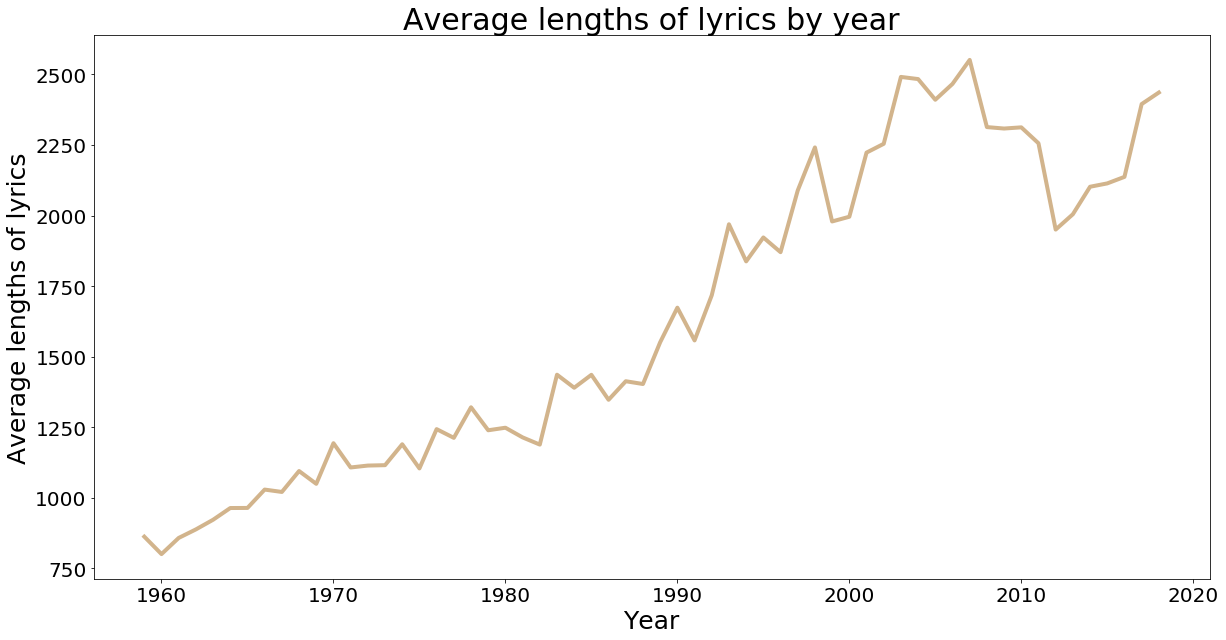

In [30]:
# [plot] avg lengths by year

avg_len = [item[1] for item in dfv.groupBy('year').mean().select(['year','avg(length)']).withColumnRenamed('avg(length)','avg_len').collect()]
year = [item[0] for item in dfv.groupBy('year').mean().select(['year','avg(length)']).withColumnRenamed('avg(length)','avg_len').collect()]
year_avg_len = {"avg_len":avg_len, "year": year}

year_avg_len = pd.DataFrame(year_avg_len)

year_avg_len = year_avg_len.sort_values(by = "year")
year_avg_len.plot(figsize = (20,10), kind = "line", color = "tan",
                               x = "year", y = "avg_len", legend = False, linewidth = 4)
plt.xlabel("Year", fontsize = 25)
plt.ylabel("Average lengths of lyrics", fontsize = 25)
plt.title("Average lengths of lyrics by year", fontsize = 30)
plt.xticks(size = 20, rotation=0)
plt.yticks(size = 20)
plt.show()

In [31]:
# [stat.] avg number of [original] tokens by year in decending order

tmp = dfv.groupBy('year').mean().select(['year','avg(tokens)']).withColumnRenamed('avg(tokens)','avg_tokens')
tb = tmp.withColumn('avg_tokens', tmp['avg_tokens'].cast(IntegerType())).orderBy(tmp['avg_tokens'].desc())
#tb.show()

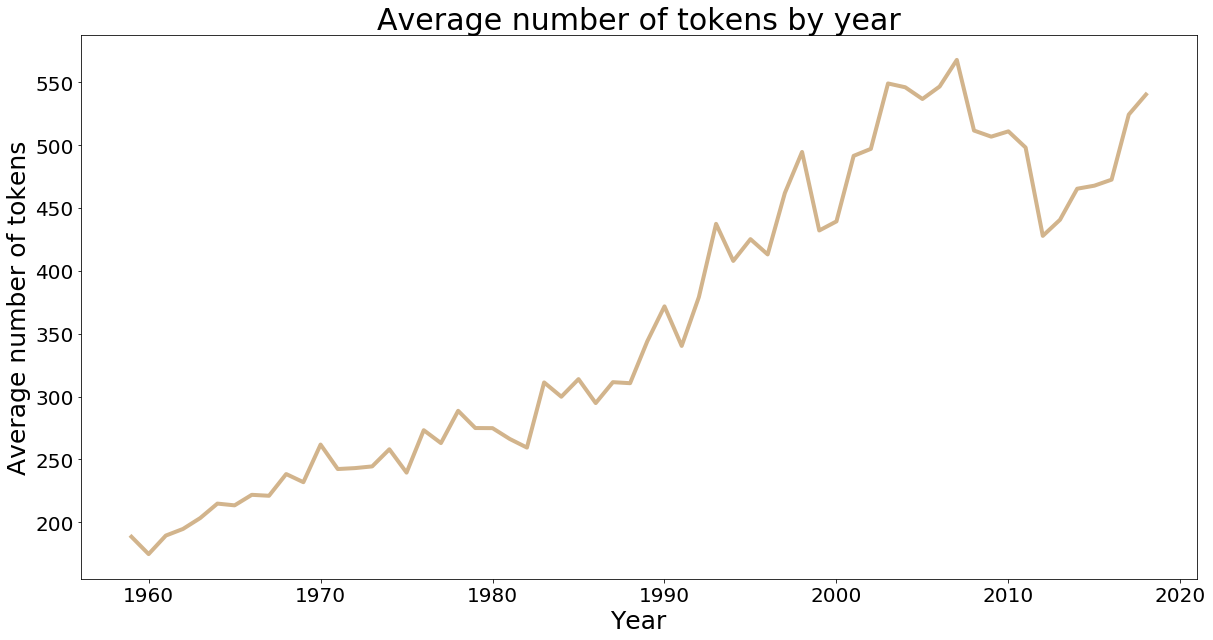

In [32]:
# [plot] avg number of tokens by year

avg_tokens = [item[1] for item in tmp.collect()]
year = [item[0] for item in tmp.collect()]
year_avg_tokens = {"avg_tokens":avg_tokens, "year": year}

year_avg_tokens = pd.DataFrame(year_avg_tokens)

year_avg_tokens = year_avg_tokens.sort_values(by = "year")
year_avg_tokens.plot(figsize = (20,10), kind = "line", color = "tan",
                               x = "year", y = "avg_tokens", legend = False, linewidth = 4)
plt.xlabel("Year", fontsize = 25)
plt.ylabel("Average number of tokens", fontsize = 25)
plt.title("Average number of tokens by year", fontsize = 30)
plt.xticks(size = 20, rotation=0)
plt.yticks(size = 20)
plt.show()

### by genre

In [33]:
regex_tokenizer = RegexTokenizer(inputCol='genres',outputCol='genre')
newdfv_genre = regex_tokenizer.transform(dfv)
newdfv_genre.select(['obsnum','genres','genre']).show()

+------+--------------------+--------------------+
|obsnum|              genres|               genre|
+------+--------------------+--------------------+
|     1|            Country |           [country]|
|     2|         Pop   Jazz |         [pop, jazz]|
|     3| Rhythm_and_Blues...|[rhythm_and_blues...|
|     4|                Pop |               [pop]|
|     5|                Pop |               [pop]|
|     6|               Rock |              [rock]|
|     7|     Country   Folk |     [country, folk]|
|     8|                    |                  []|
|     9| Rhythm_and_Blues...|[rhythm_and_blues...|
|    10|                Pop |               [pop]|
|    12|                Pop |               [pop]|
|    13| Pop   Rhythm_and...|[pop, rhythm_and_...|
|    14|               Rock |              [rock]|
|    15|                Pop |               [pop]|
|    16|   Rhythm_and_Blues |  [rhythm_and_blues]|
|    17| Pop   Rhythm_and...|[pop, rhythm_and_...|
|    18|     Easy_Listening |  

In [34]:
new = newdfv_genre.withColumn('genre', explode('genre'))
new.select(['obsnum','genres','genre','features_new']).show()

+------+--------------------+----------------+--------------------+
|obsnum|              genres|           genre|        features_new|
+------+--------------------+----------------+--------------------+
|     1|            Country |         country|(262145,[14,4200,...|
|     2|         Pop   Jazz |             pop|(262145,[571,2325...|
|     2|         Pop   Jazz |            jazz|(262145,[571,2325...|
|     3| Rhythm_and_Blues...|rhythm_and_blues|(262145,[30006,31...|
|     3| Rhythm_and_Blues...|             pop|(262145,[30006,31...|
|     4|                Pop |             pop|(262145,[8449,137...|
|     5|                Pop |             pop|(262145,[2437,576...|
|     6|               Rock |            rock|(262145,[4200,576...|
|     7|     Country   Folk |         country|(262145,[2710,420...|
|     7|     Country   Folk |            folk|(262145,[2710,420...|
|     9| Rhythm_and_Blues...|rhythm_and_blues|(262145,[16640,18...|
|     9| Rhythm_and_Blues...|            rock|(2

In [35]:
new.printSchema()

root
 |-- artist: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- song: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- obsnum: integer (nullable = true)
 |-- url: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- country: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens: integer (nullable = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- grams2: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- grams3: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- rawFeatures: vector (nullable = true)
 |-- idf: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- CVFeatures: vector (nullable = true)
 |-- cleanLyrics: string (nullable = true)
 |-- length: integer (nullable = true)
 |-- features_new: vector (nullabl

In [36]:
new.select(['filtered','genre']).show()

+--------------------+----------------+
|            filtered|           genre|
+--------------------+----------------+
|[took, little, tr...|         country|
|[shark, babe, tee...|             pop|
|[shark, babe, tee...|            jazz|
|[tried, prove, lo...|rhythm_and_blues|
|[tried, prove, lo...|             pop|
|[venus, venus, ve...|             pop|
|[lonely, boy, lon...|             pop|
|[every, night, ho...|            rock|
|[village, hidden,...|         country|
|[village, hidden,...|            folk|
|[going, kansas, c...|rhythm_and_blues|
|[going, kansas, c...|            rock|
|[guardian, star, ...|             pop|
|[put, head, shoul...|             pop|
|[night, clear, mo...|             pop|
|[night, clear, mo...|rhythm_and_blues|
|[donna, donna, do...|            rock|
|[got, guy, name, ...|             pop|
|[asked, knew, tru...|rhythm_and_blues|
|[fe, fe, fi, fi, ...|             pop|
+--------------------+----------------+
only showing top 20 rows



In [37]:
# [stat.] avg lengths by genre in decending order

tmp = new.filter(new['genre']!='nan')
tmp = tmp.groupBy('genre').mean().select(['genre','avg(length)']).withColumnRenamed('avg(length)','avg_len')
tb = tmp.withColumn('avg_len', tmp['avg_len'].cast(IntegerType())).orderBy(tmp['avg_len'].desc())
tb.show()

+----------------+-------+
|           genre|avg_len|
+----------------+-------+
|       caribbean|   2181|
|         hip_hop|   2028|
|       a_capella|   1875|
|           latin|   1831|
|     avant_garde|   1729|
|      electronic|   1720|
|rhythm_and_blues|   1631|
|            afro|   1612|
|             pop|   1601|
|         country|   1502|
|           blues|   1490|
|            rock|   1461|
|          comedy|   1423|
|            folk|   1401|
|            jazz|   1231|
|  easy_listening|   1153|
+----------------+-------+



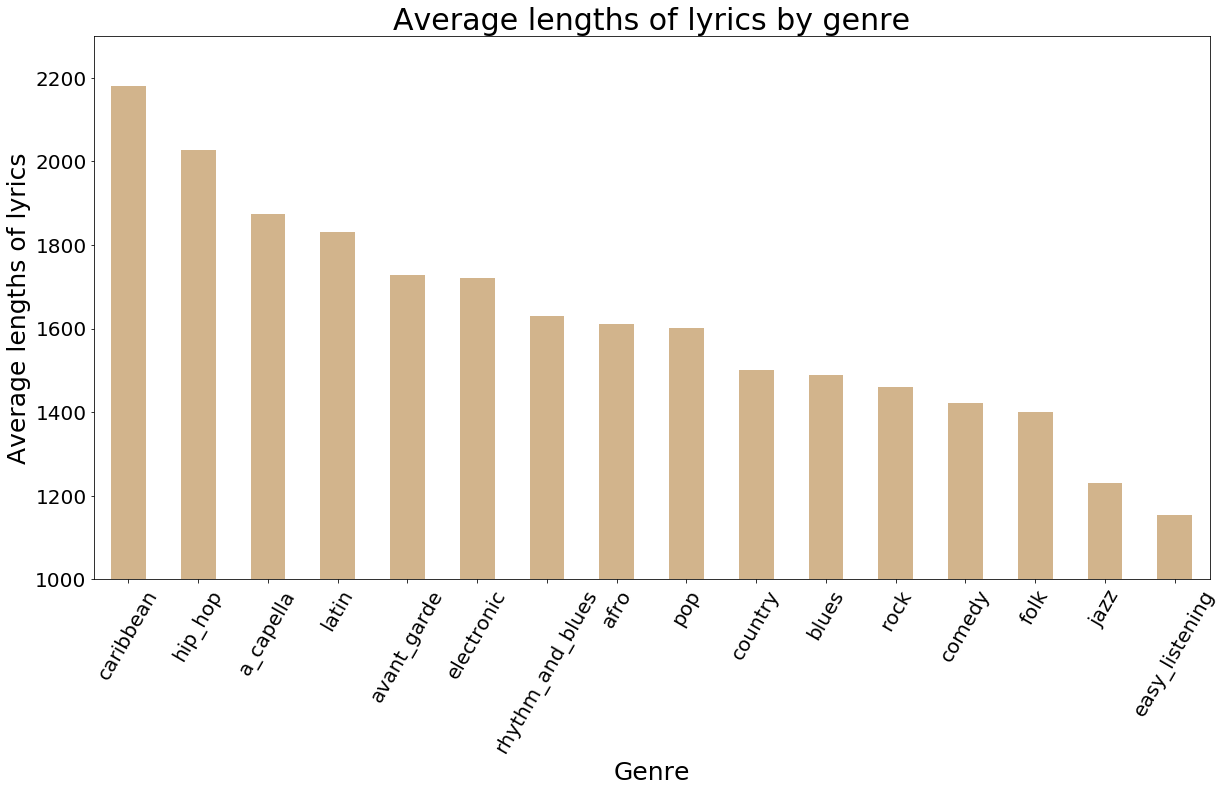

In [39]:
# [plot] avg lengths by year

avg_len = [item[1] for item in tb.collect()]
genre = [item[0] for item in tb.collect()]
genre_avg_len = {"avg_len":avg_len, "genre": genre}

genre_avg_len = pd.DataFrame(genre_avg_len)

genre_avg_len = genre_avg_len.sort_values(by = "avg_len",ascending=False)
genre_avg_len.plot(figsize = (20,10), kind = "bar", color = "tan",
                               x = "genre", y = "avg_len", legend = False)
plt.xlabel("Genre", fontsize = 25)
plt.ylabel("Average lengths of lyrics", fontsize = 25)
plt.title("Average lengths of lyrics by genre", fontsize = 30)
plt.xticks(size = 20, rotation=60)
plt.yticks(size = 20)
plt.ylim([1000,2300])
plt.show()

### by country 

In [89]:
# [stat.] number of records by country in decending order

#tmp0 = dfv.withColumn('country',when(~dfv.country.isin(['US','UK','Canada','Australia','Scotland']), 'Other').otherwise(dfv['country']))
tmp = dfv.groupBy('country').count().select(['country','count'])
tb = tmp.withColumn('count', tmp['count'].cast(IntegerType())).orderBy(tmp['count'].desc())
tb.show()

+------------+-----+
|     country|count|
+------------+-----+
|          US| 3987|
|          UK|  680|
|      Canada|  190|
|   Australia|   72|
|    Scotland|   37|
|      Sweden|   35|
|         USA|   32|
|    Barbados|   32|
|         US1|   26|
|     Jamaica|   24|
|     Ireland|   22|
|     Germany|   22|
|      France|   16|
|       Wales|   14|
|West Germany|   12|
|         UK1|   11|
|       Spain|   11|
|        USUS|    9|
| Netherlands|    9|
|    Colombia|    8|
+------------+-----+
only showing top 20 rows



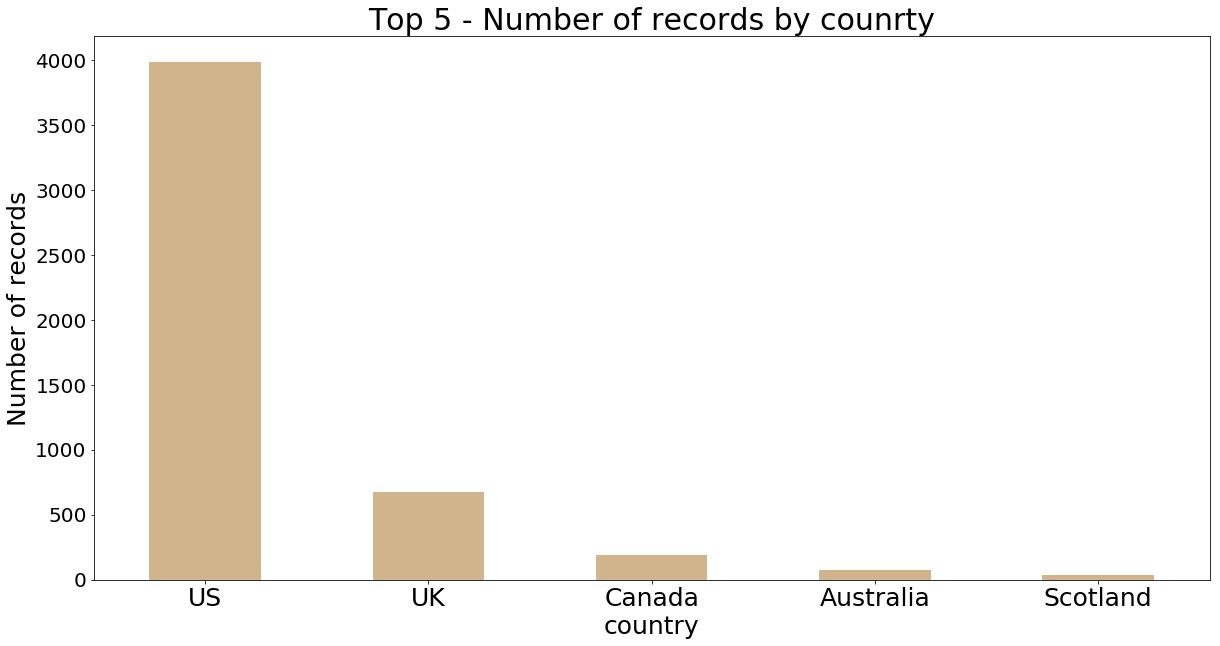

In [90]:
# [plot] number of records by country

count = [item[1] for item in tb.collect()]
country = [item[0] for item in tb.collect()]
country_count = {"count":count, "country": country}

country_count = pd.DataFrame(country_count).head(5)

country_count = country_count.sort_values(by = "count", ascending=False)
country_count.plot(figsize = (20,10), kind = "bar", color = "tan",
                               x = "country", y = "count", legend = False)
plt.xlabel("country", fontsize = 25)
plt.ylabel("Number of records", fontsize = 25)
plt.title("Top 5 - Number of records by counrty", fontsize = 30)
plt.xticks(size = 25, rotation=0)
plt.yticks(size = 20)
plt.show()

## Natural Language Processing
Text Mining

### Part 1: N-grams

In [91]:
# convert a spark df column to a list
#lyricsText = dfv.select('words').rdd.flatMap(lambda x: x).collect()

In [92]:
# [NEW] explode 'words' column (comma-separated values into rows)
newDF1 = dfv.withColumn('filtered', explode('filtered'))
newDF2 = dfv.withColumn('grams2', explode('grams2'))
newDF3 = dfv.withColumn('grams3', explode('grams3'))
explodedDF1 = newDF1
explodedDF2 = newDF2
explodedDF3 = newDF3

newDF3.select(['year','grams3']).show() # make sure the punctuations..have been removed

+----+--------------------+
|year|              grams3|
+----+--------------------+
|1959|    took little trip|
|1959|   little trip along|
|1959|  trip along colonel|
|1959|along colonel jac...|
|1959|colonel jackson m...|
|1959|jackson mighty mi...|
|1959|mighty mississip ...|
|1959|mississip took li...|
|1959|   took little bacon|
|1959|   little bacon took|
|1959|   bacon took little|
|1959|   took little beans|
|1959| little beans caught|
|1959| beans caught bloody|
|1959|caught bloody bri...|
|1959| bloody british near|
|1959|   british near town|
|1959|       near town new|
|1959|    town new orleans|
|1959|   new orleans fired|
+----+--------------------+
only showing top 20 rows



In [93]:
numrecords1 = newDF1.count()
print ('# of records in newDF1: ' + str(numrecords1))

# of records in newDF1: 865300


In [94]:
# filter out word length <= 3..
#newDF1 = newDF1.filter(length(newDF1['filtered']) > 3)

In [105]:
# [stat.] 'filtered' words frequency count

tmp = newDF1.groupBy('filtered').count().alias('count')
tb = tmp.withColumn('count', tmp['count'].cast(IntegerType())).orderBy(tmp['count'].desc())
#tb.show()

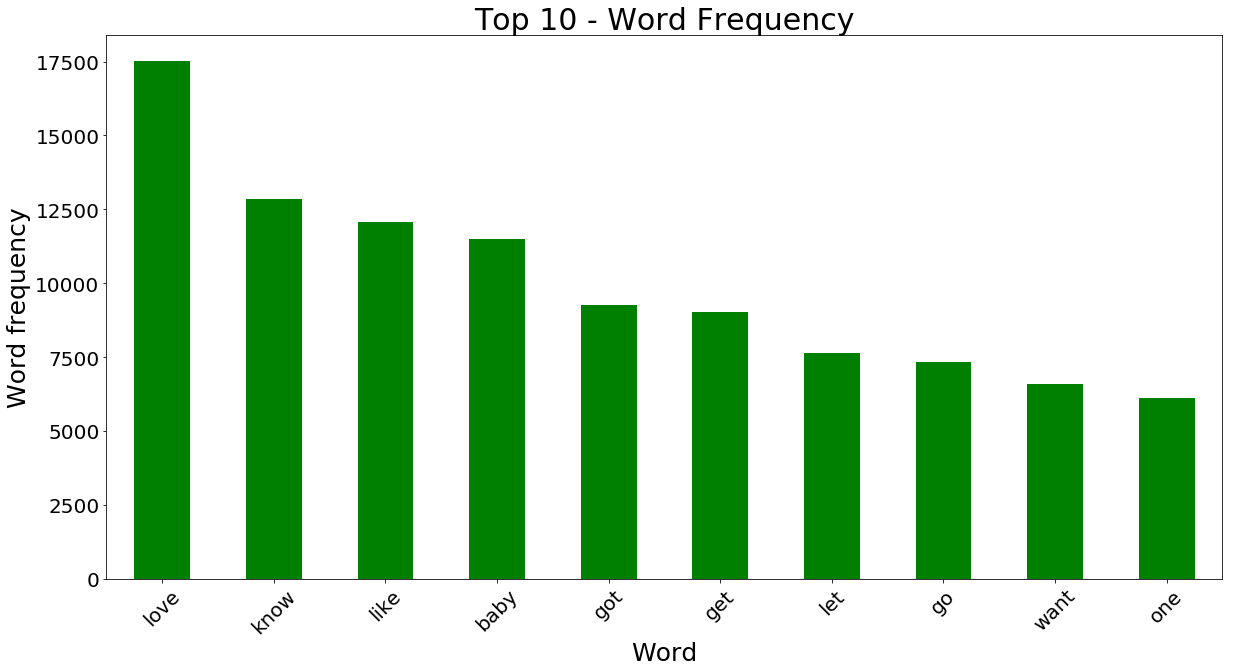

In [106]:
# [plot] word frequency count - pic...

count = [item[1] for item in tb.collect()]
words = [item[0] for item in tb.collect()]
words_count = {"count":count, "words": words}

words_count = pd.DataFrame(words_count).head(10)

words_count = words_count.sort_values(by = "count",ascending=False)
words_count.plot(figsize = (20,10), kind = "bar", color = "green",
                               x = "words", y = "count", legend = False)
plt.xlabel("Word", fontsize = 25)
plt.ylabel("Word frequency", fontsize = 25)
plt.title("Top 10 - Word Frequency", fontsize = 30)
plt.xticks(size = 20, rotation=45)
plt.yticks(size = 20)
plt.show()

In [107]:
# [stat.] ngrams=2 frequency count

tmp = newDF2.groupBy('grams2').count().alias('count')
tb = tmp.withColumn('count', tmp['count'].cast(IntegerType())).orderBy(tmp['count'].desc())
#tb.show()

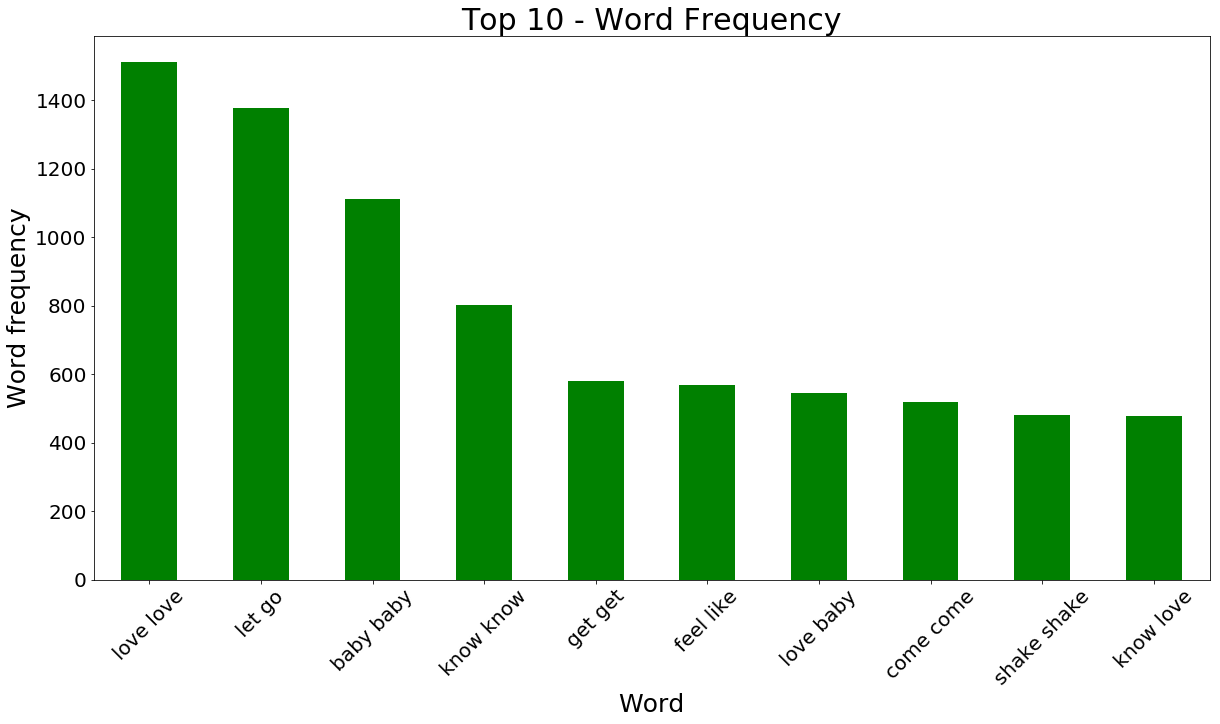

In [108]:
# [plot] ngrams=2 frequency count - pic...

count = [item[1] for item in tb.collect()]
grams2 = [item[0] for item in tb.collect()]
grams2_count = {"count":count, "grams2": grams2}

grams2_count = pd.DataFrame(grams2_count).head(10)

grams2_count = grams2_count.sort_values(by = "count",ascending=False)
grams2_count.plot(figsize = (20,10), kind = "bar", color = "green",
                               x = "grams2", y = "count", legend = False)
#plt.xlabel("Grams2", fontsize = 25)
#plt.ylabel("Grams2 Frequency", fontsize = 25)
#plt.title("Top 10 - 2 Grams Frequency", fontsize = 30)
#plt.xticks(size = 20, rotation=45)
#plt.yticks(size = 20)
#plt.show()

plt.xlabel("Word", fontsize = 25)
plt.ylabel("Word frequency", fontsize = 25)
plt.title("Top 10 - Word Frequency", fontsize = 30)
plt.xticks(size = 20, rotation=45)
plt.yticks(size = 20)
plt.show()

In [109]:
# [stat.] ngrams=3 frequency count

tmp = newDF3.groupBy('grams3').count().alias('count')
tb = tmp.withColumn('count', tmp['count'].cast(IntegerType())).orderBy(tmp['count'].desc())
#tb.show()

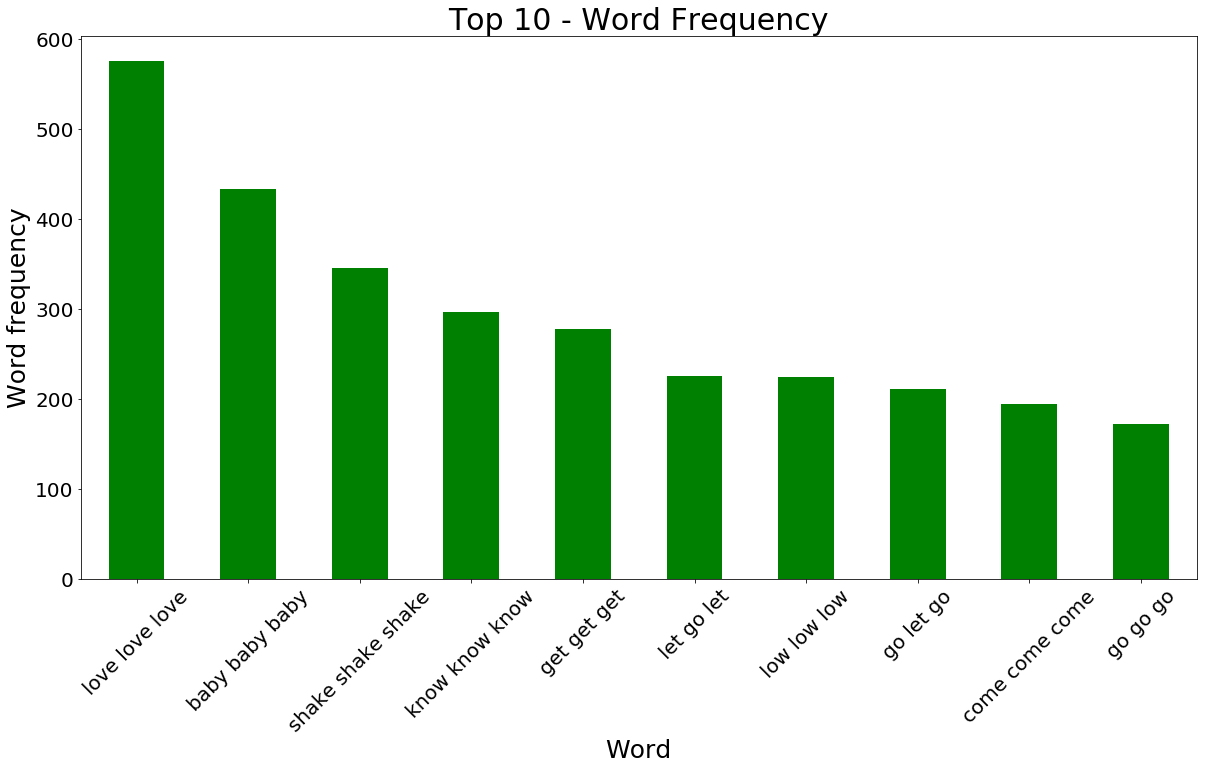

In [110]:
# [plot] ngrams=3 frequency count

count = [item[1] for item in tb.collect()]
grams3 = [item[0] for item in tb.collect()]
grams3_count = {"count":count, "grams3": grams3}

grams3_count = pd.DataFrame(grams3_count).head(10)

grams3_count = grams3_count.sort_values(by = "count",ascending=False)
grams3_count.plot(figsize = (20,10), kind = "bar", color = "green",
                               x = "grams3", y = "count", legend = False)
#plt.xlabel("Grams3", fontsize = 25)
#plt.ylabel("Grams3 Frequency", fontsize = 25)
#plt.title("Top 10 - 3 Grams Frequency", fontsize = 30)
#plt.xticks(size = 20, rotation=45)
#plt.yticks(size = 20)
#plt.show()

plt.xlabel("Word", fontsize = 25)
plt.ylabel("Word frequency", fontsize = 25)
plt.title("Top 10 - Word Frequency", fontsize = 30)
plt.xticks(size = 20, rotation=45)
plt.yticks(size = 20)
plt.show()

### Part 2: Sentiment Analysis

In [59]:
#newDF1.select('filtered').show()

In [60]:
# [new] pos vs. neg

with open('data/positive-words.txt') as f:
    posWords = f.read().splitlines()

with open('data/negative-words.txt') as f:
    negWords = f.read().splitlines()

def pos_neg(word):
    """
    positive vs. negative words
    """
    if str(word) in posWords:
        res = 'Positive'
    elif str(word) in negWords:
        res = 'Negative'
    else:
        res = ''
    return res

pos_neg_fun = udf(lambda x: pos_neg(x), StringType())
newDF1 = newDF1.withColumn('pos_neg_word',pos_neg_fun(col('filtered')))
newDF1.select(['filtered','pos_neg_word']).show()

# -- 
#sid = SentimentIntensityAnalyzer()

#def pos_neg(word):
    #if (sid.polarity_scores(word)['compound']) >= 0.5:
        #res = 'Positive'
    #elif (sid.polarity_scores(word)['compound']) <= 0.5:
        #res = 'Negative'
    #else:
        #res = 'Neutral'
    #return res

#pos_neg_fun = udf(lambda x: pos_neg(x), StringType())
#newDFV = dfv.withColumn('posNegWord',pos_neg_fun(col('filtered')))
#newDFV.show()

+---------+------------+
| filtered|pos_neg_word|
+---------+------------+
|     took|            |
|   little|            |
|     trip|            |
|    along|            |
|  colonel|            |
|  jackson|            |
|   mighty|    Positive|
|mississip|            |
|     took|            |
|   little|            |
|    bacon|            |
|     took|            |
|   little|            |
|    beans|            |
|   caught|            |
|   bloody|    Negative|
|  british|            |
|     near|            |
|     town|            |
|      new|            |
+---------+------------+
only showing top 20 rows



In [61]:
# [stat.] percentage by pos_neg_word, year

tmp0  = newDF1.filter(newDF1['pos_neg_word'] != '')
tmp0.createOrReplaceTempView('TABLE0')

# window function
tmp1 = spark.sql("SELECT pos_neg_word, year, \
        COUNT(*) OVER w_posneg_year AS n, \
        (0.0+COUNT(*) OVER w_posneg_year)/(COUNT(*) OVER (PARTITION BY year)) AS pct \
        FROM TABLE0 \
        WINDOW w_posneg_year AS (PARTITION BY pos_neg_word, year)")
#tmp1.show( )

In [62]:
# remove duplicate rows

tmp1.registerTempTable("x")
tmp2 = spark.sql("SELECT * FROM( SELECT *, \
        ROW_NUMBER()OVER(PARTITION BY pos_neg_word, \
        year, n, pct ORDER BY year) rn FROM x) y WHERE rn = 1")
tmp2.show()

+------------+----+----+-------------------+---+
|pos_neg_word|year|   n|                pct| rn|
+------------+----+----+-------------------+---+
|    Negative|1959| 387|0.37572815533980583|  1|
|    Positive|1959| 643|0.62427184466019417|  1|
|    Negative|1990| 973|0.39472616632860041|  1|
|    Positive|1990|1492|0.60527383367139959|  1|
|    Negative|1975| 471|0.29182156133828996|  1|
|    Positive|1975|1143|0.70817843866171004|  1|
|    Negative|1977| 535|0.31213535589264877|  1|
|    Positive|1977|1179|0.68786464410735123|  1|
|    Negative|2003|1446|0.44602097470697101|  1|
|    Positive|2003|1796|0.55397902529302899|  1|
|    Negative|2007|1540|0.41825095057034221|  1|
|    Positive|2007|2142|0.58174904942965779|  1|
|    Negative|2018|1601|0.46622015142690740|  1|
|    Positive|2018|1833|0.53377984857309260|  1|
|    Negative|1974| 513|0.31823821339950372|  1|
|    Positive|1974|1099|0.68176178660049628|  1|
|    Negative|2015|1428|0.45089990527312914|  1|
|    Positive|2015|1

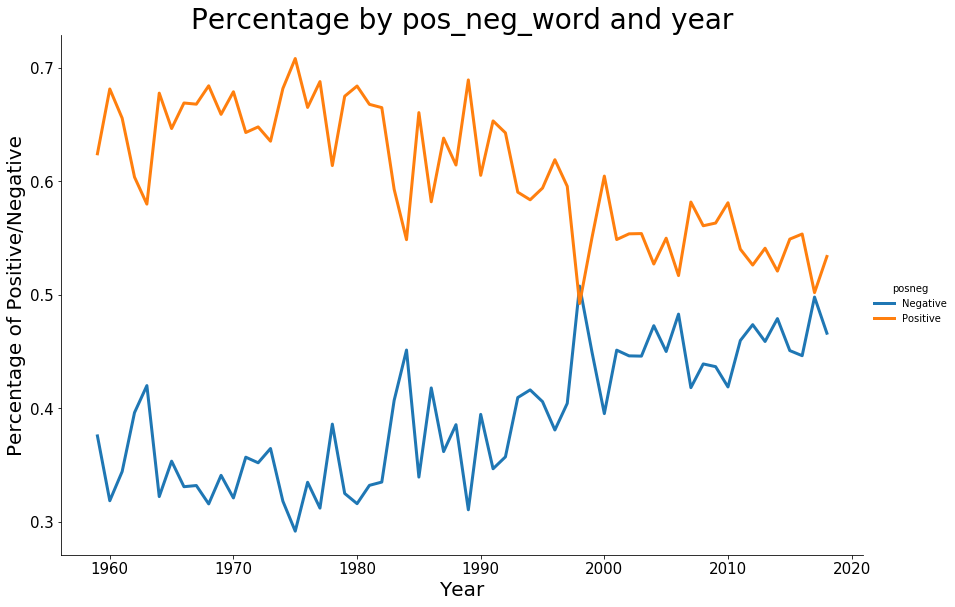

In [68]:
# [plot] pos_neg count by year

perc = tmp2.select(['pos_neg_word','year','pct']).collect()

posneg = [item[0] for item in perc]
year = [item[1] for item in perc]
pct = [item[2] for item in perc]

posneg_byYear = {"pct": pct, "year": year, "posneg": posneg}
posneg_byYear = pd.DataFrame(posneg_byYear)
posneg_byYear = posneg_byYear.sort_values(by = "year", ascending  = True)

g = sns.FacetGrid(posneg_byYear, hue="posneg", height = 8, aspect = 1.5)
g.map(plt.plot, "year", "pct", linewidth = 3)
g.add_legend()
plt.ylabel("Percentage of Positive/Negative", fontsize = 20)
plt.xlabel("Year", fontsize = 20)
plt.title("Percentage by pos_neg_word and year", fontsize = 28)
plt.xticks(size = 15, rotation=0)
plt.yticks(size = 15)
plt.show()

In [69]:
# Alternatively, using VADER

# initialize VADER
#nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# [new] get sentiment scores (neg, neu, pos, compound)
# - compound > 0: pos; < 0: neg
get_compound_score = udf(lambda x: float(sid.polarity_scores(x)['compound']), FloatType())
new1 = newDF1.withColumn('sentScore', get_compound_score(col('filtered')))
new1.select('sentScore').show()

+---------+
|sentScore|
+---------+
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
|  -0.4404|
|      0.0|
|      0.0|
|      0.0|
|      0.0|
+---------+
only showing top 20 rows



In [70]:
# [stat.] average sentiment scores over time

tmp = new1.groupBy('year').mean().select(['year','avg(sentScore)']).withColumnRenamed('avg(sentScore)','avg_sent_score')
tb = tmp.withColumn('avg_sent_score',tmp['avg_sent_score'].cast(FloatType())).orderBy(tmp['avg_sent_score'].desc())
tb.show()

+----+--------------+
|year|avg_sent_score|
+----+--------------+
|1976|   0.057401564|
|1960|   0.051990464|
|1989|    0.05184321|
|1975|    0.05109243|
|1965|   0.049006328|
|1964|   0.047123738|
|1981|    0.04635853|
|1967|   0.045315865|
|1979|   0.044008195|
|1985|   0.043352403|
|1961|   0.043190077|
|1991|    0.04295561|
|1977|   0.042043418|
|1978|   0.041924506|
|1982|   0.041910727|
|1992|   0.041831754|
|1974|    0.04181995|
|1962|   0.041610118|
|1980|   0.041047543|
|1968|   0.039035022|
+----+--------------+
only showing top 20 rows



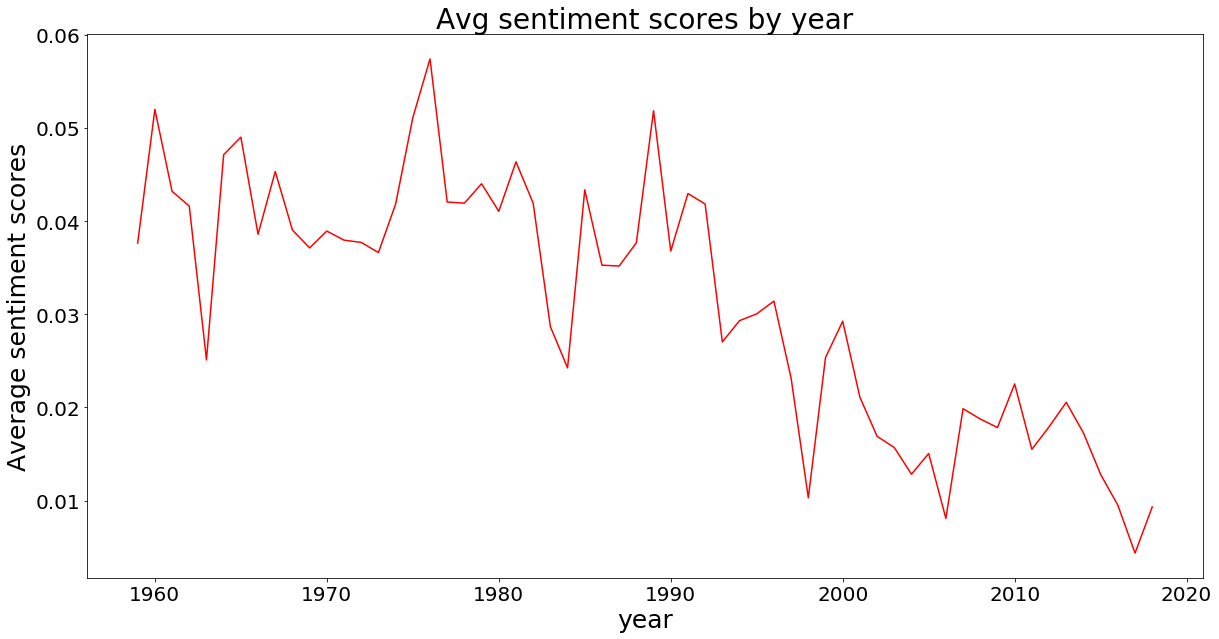

In [71]:
# [plot] avg sentiment score by year

avg_ss = [item[1] for item in new1.groupBy('year').mean().select(['year','avg(sentScore)']).withColumnRenamed('avg(sentScore)','avg_sentScore').collect()]
year = [item[0] for item in new1.groupBy('year').mean().select(['year','avg(sentScore)']).withColumnRenamed('avg(sentScore)','avg_sentScore').collect()]
year_avg_ss = {"avg_ss":avg_ss, "year": year}

year_avg_ss = pd.DataFrame(year_avg_ss)

year_avg_ss = year_avg_ss.sort_values(by = "year")
year_avg_ss.plot(figsize = (20,10), kind = "line", color = "red",
                               x = "year", y = "avg_ss", legend = False)
plt.xlabel("year", fontsize = 25)
plt.ylabel("Average sentiment scores", fontsize = 25)
plt.title("Avg sentiment scores by year", fontsize = 28)
plt.xticks(size = 20, rotation=0)
plt.yticks(size = 20)
plt.show()

In [75]:
# ** avg sentiment scores by genre **#

new_f = new.withColumn('filtered', explode('filtered')).filter(new['genre']!='nan')

In [76]:
# [stat.] average sentiment scores by genre

tmp = new_f.withColumn('sentScore', get_compound_score(col('filtered')))
tmp = tmp.groupBy('genre').mean().select(['genre','avg(sentScore)']).withColumnRenamed('avg(sentScore)','avg_sent_score')
tb = tmp.withColumn('avg_sent_score',tmp['avg_sent_score'].cast(FloatType())).orderBy(tmp['avg_sent_score'].desc())
tb.show()

+----------------+--------------+
|           genre|avg_sent_score|
+----------------+--------------+
|            jazz|    0.03738581|
|           blues|     0.0369385|
|            rock|    0.03107398|
|      electronic|   0.030961707|
|             pop|   0.029607609|
|rhythm_and_blues|   0.028334746|
|          comedy|   0.026443372|
|       a_capella|   0.026322892|
|           latin|   0.026181903|
|            folk|   0.024987193|
|         country|    0.02318367|
|       caribbean|   0.023049923|
|         hip_hop|   0.019546125|
|  easy_listening|   0.019152442|
|     avant_garde|  -0.009197661|
|            afro|  -0.010443885|
+----------------+--------------+



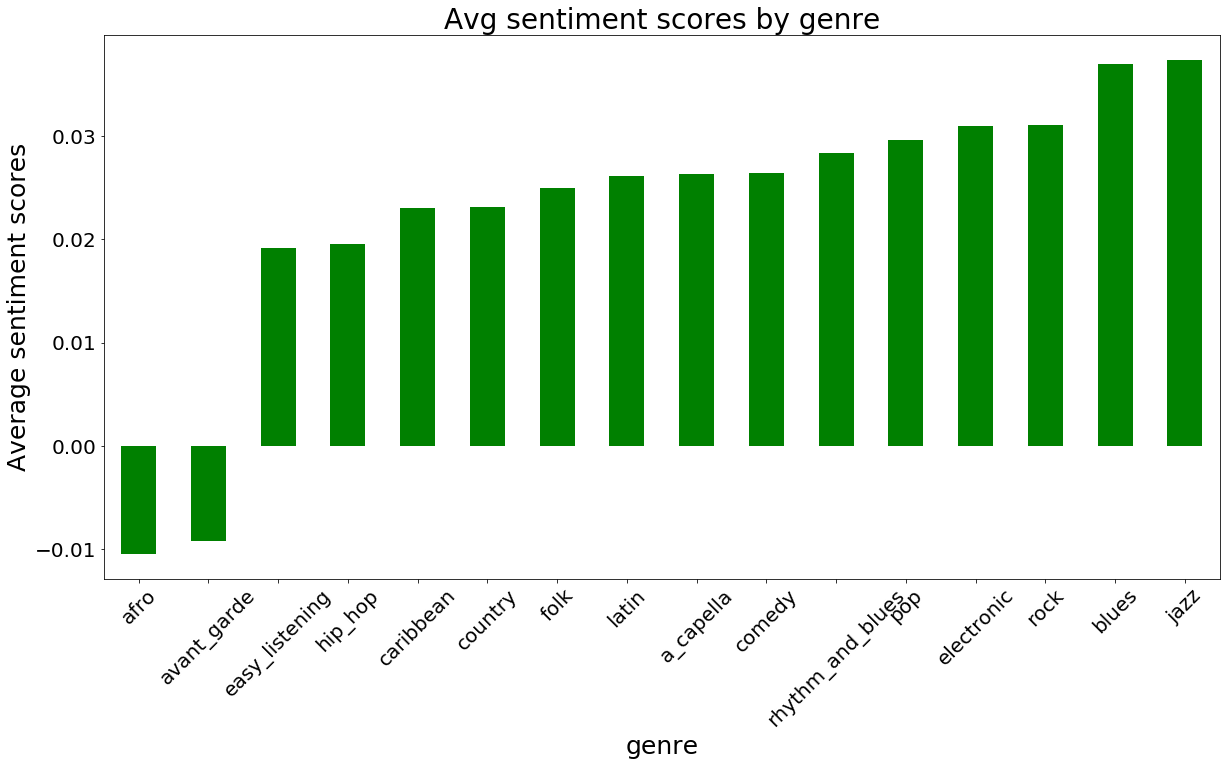

In [77]:
# [plot] avg sentiment score by year

avg_ss = [item[1] for item in tb.collect()]
genre = [item[0] for item in tb.collect()]
genre_avg_ss = {"avg_ss":avg_ss, "genre": genre}

genre_avg_ss = pd.DataFrame(genre_avg_ss)

genre_avg_ss = genre_avg_ss.sort_values(by = "avg_ss")
genre_avg_ss.plot(figsize = (20,10), kind = "bar", color = "green",
                               x = "genre", y = "avg_ss", legend = False)
plt.xlabel("genre", fontsize = 25)
plt.ylabel("Average sentiment scores", fontsize = 25)
plt.title("Avg sentiment scores by genre", fontsize = 28)
plt.xticks(size = 20, rotation=45)
plt.yticks(size = 20)
plt.show()

### Part 3: TF-IDF

TF-IDF stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining.
This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus.

In [53]:
dfv.printSchema()

root
 |-- artist: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- song: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- obsnum: integer (nullable = true)
 |-- url: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- country: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens: integer (nullable = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- grams2: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- grams3: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- rawFeatures: vector (nullable = true)
 |-- idf: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- CVFeatures: vector (nullable = true)
 |-- cleanLyrics: string (nullable = true)
 |-- length: integer (nullable = true)
 |-- features_new: vector (nullable = true)
 |-- decade: string (nullabl

In [46]:
TFIDF = dfv.withColumn('token',explode('filtered')).withColumnRenamed('obsnum','doc_id').withColumnRenamed('filtered','document').select('document','doc_id','token')
TFIDF.show()

+--------------------+------+---------+
|            document|doc_id|    token|
+--------------------+------+---------+
|[took, little, tr...|     1|     took|
|[took, little, tr...|     1|   little|
|[took, little, tr...|     1|     trip|
|[took, little, tr...|     1|    along|
|[took, little, tr...|     1|  colonel|
|[took, little, tr...|     1|  jackson|
|[took, little, tr...|     1|   mighty|
|[took, little, tr...|     1|mississip|
|[took, little, tr...|     1|     took|
|[took, little, tr...|     1|   little|
|[took, little, tr...|     1|    bacon|
|[took, little, tr...|     1|     took|
|[took, little, tr...|     1|   little|
|[took, little, tr...|     1|    beans|
|[took, little, tr...|     1|   caught|
|[took, little, tr...|     1|   bloody|
|[took, little, tr...|     1|  british|
|[took, little, tr...|     1|     near|
|[took, little, tr...|     1|     town|
|[took, little, tr...|     1|      new|
+--------------------+------+---------+
only showing top 20 rows



In [47]:
# [new] (TFIDF) calculate TF
# - the number of times a word appears in a document

tf = TFIDF.groupBy(['doc_id','token']).agg({'document':'count'}).withColumnRenamed('count(document)','tf')
tf.show()
tf.createOrReplaceTempView('tb1')

+------+---------+---+
|doc_id|    token| tf|
+------+---------+---+
|     2|   mackie|  4|
|     7|   prayed|  3|
|    15|      tan|  8|
|    17|  english|  2|
|    23|     bump|  1|
|    29|   wonder|  4|
|    35|everybody|  4|
|    41|  conceal|  1|
|    41|     view|  2|
|    67|      let|  4|
|    68|     hear|  2|
|    69|    spine|  2|
|    73|     must|  1|
|    81|     call|  1|
|    85|     stop|  1|
|    87|   softer|  1|
|    89|      sea|  7|
|    89|interlude|  1|
|   120|    right|  1|
|   123|   really|  1|
+------+---------+---+
only showing top 20 rows



In [48]:
# [new] (TFIDF) calculate DF
# - number of documents containing word

mydf = TFIDF.groupBy('token').agg(countDistinct('doc_id')).withColumnRenamed('count(DISTINCT doc_id)','df')
mydf.show()
mydf.createOrReplaceTempView('tb2')

+----------+---+
|     token| df|
+----------+---+
|     still|914|
|     verte|  1|
|      hope|352|
|    travel| 29|
|    waters| 13|
|   lyrical| 18|
| recognize| 29|
|  tripping| 16|
|   embrace| 32|
|   jewelry| 19|
|    freaks| 17|
|     spoil| 14|
|paramedics|  1|
|      foxy|  5|
|     inner| 12|
|    harder| 80|
|    doubts| 15|
|strawberry| 10|
|    gloria|  4|
|  everyday|103|
+----------+---+
only showing top 20 rows



In [49]:
# join the two tables

TFIDF1 = spark.sql("SELECT tb1.doc_id, tb1.token, tb1.tf, tb2.df \
        FROM tb1 LEFT JOIN tb2 ON tb1.token = tb2.token")
TFIDF1.show()

+------+---------+---+---+
|doc_id|    token| tf| df|
+------+---------+---+---+
|  4351|amplifier|  1|  1|
|  3952|    anime|  1|  1|
|  4552|arguments|  1|  4|
|  2825|arguments|  1|  4|
|  3390|arguments|  1|  4|
|  3990|arguments|  1|  4|
|  5381|      art|  1| 19|
|  1616|      art|  1| 19|
|  5438|      art|  2| 19|
|  3109|      art|  1| 19|
|  5485|      art|  2| 19|
|  3803|      art|  1| 19|
|  5594|      art|  3| 19|
|  1587|      art|  7| 19|
|  3328|      art|  2| 19|
|  5468|      art|  1| 19|
|  4033|      art|  1| 19|
|   354|      art|  2| 19|
|  5820|      art|  1| 19|
|  5398|      art|  2| 19|
+------+---------+---+---+
only showing top 20 rows



In [50]:
TFIDF1.printSchema()

root
 |-- doc_id: integer (nullable = true)
 |-- token: string (nullable = true)
 |-- tf: long (nullable = false)
 |-- df: long (nullable = true)



In [51]:
# [new] (TFIDF) calculate IDF

TFIDF_fun = udf(lambda x,y: y*math.log((numrecords+1)/(x+1)),FloatType())
TFIDF2 = TFIDF1.withColumn('tfidf', TFIDF_fun(col('df'),col('tf')))
TFIDF2.show()
TFIDF2.createOrReplaceTempView('TFIDF2')

+------+---------+---+---+---------+
|doc_id|    token| tf| df|    tfidf|
+------+---------+---+---+---------+
|  4351|amplifier|  1|  1|7.8950634|
|  3952|    anime|  1|  1|7.8950634|
|  4552|arguments|  1|  4| 6.978214|
|  2825|arguments|  1|  4| 6.978214|
|  3390|arguments|  1|  4| 6.978214|
|  3990|arguments|  1|  4| 6.978214|
|  5381|      art|  1| 19| 5.590987|
|  1616|      art|  1| 19| 5.590987|
|  5438|      art|  2| 19|11.181974|
|  3109|      art|  1| 19| 5.590987|
|  5485|      art|  2| 19|11.181974|
|  3803|      art|  1| 19| 5.590987|
|  5594|      art|  3| 19| 16.77296|
|  1587|      art|  7| 19| 39.13691|
|  3328|      art|  2| 19|11.181974|
|  5468|      art|  1| 19| 5.590987|
|  4033|      art|  1| 19| 5.590987|
|   354|      art|  2| 19|11.181974|
|  5820|      art|  1| 19| 5.590987|
|  5398|      art|  2| 19|11.181974|
+------+---------+---+---+---------+
only showing top 20 rows



In [52]:
# merge back to get other attributes... (e.g. decade, genre...)

TMPALL0 = dfv.select(['decade','obsnum'])
TMPALL0.createOrReplaceTempView('TMPALL0')

TMPALL1 = spark.sql("SELECT TMPALL0.obsnum, TMPALL0.decade, \
            TFIDF2.token, TFIDF2.tfidf \
            FROM TMPALL0 \
            LEFT JOIN TFIDF2 on TMPALL0.obsnum = TFIDF2.doc_id")
TMPALL1.show()

+------+---------+-------+---------+
|obsnum|   decade|  token|    tfidf|
+------+---------+-------+---------+
|   463|1959-1969|   luck|4.5217886|
|   463|1959-1969|   lose| 5.278115|
|   463|1959-1969|   hand|2.1972246|
|   463|1959-1969|    saw|5.7807436|
|   463|1959-1969|wedding|15.168737|
|   463|1959-1969|   ring|10.397207|
|   463|1959-1969|    eye|6.7345915|
|   463|1959-1969|   jack| 18.17318|
|   463|1959-1969|  night|1.0986123|
|   463|1959-1969|   king|26.646637|
|   463|1959-1969| regret|4.7361984|
|   463|1959-1969| played|15.567281|
|   463|1959-1969|thought|4.6051702|
|   463|1959-1969|    ace|18.307676|
|   463|1959-1969|  cards|4.6728287|
|   463|1959-1969|   make|0.6931472|
|   463|1959-1969|stacked|6.3902407|
|   463|1959-1969|   away|1.3862944|
|   463|1959-1969|   made|3.8918202|
|   463|1959-1969|   lady|3.1354942|
+------+---------+-------+---------+
only showing top 20 rows



In [53]:
# [stat.] TF-IDF by decade

tmp = TMPALL1.select(['decade','token','tfidf'])
col_list = ['decade']
window = Window.partitionBy([col(x) for x in col_list]).orderBy(tmp['tfidf'].desc())

tb = tmp.select('*',rank().over(window).alias('rank')).filter(col('rank') <= 20)
tb.show()

+---------+--------+---------+----+
|   decade|   token|    tfidf|rank|
+---------+--------+---------+----+
|1970-1979|     chh| 852.6669|   1|
|1970-1979|  chance| 765.2345|   2|
|1970-1979|     aha|  485.204|   3|
|1970-1979|   gimme|418.96548|   4|
|1970-1979|   float|362.41208|   5|
|1970-1979|    whop|355.88892|   6|
|1970-1979|  bennie|329.53412|   7|
|1970-1979|   willy| 313.1218|   8|
|1970-1979|   shake|309.80865|   9|
|1970-1979|    take| 304.3156|  10|
|1970-1979|   julie|299.57648|  11|
|1970-1979|  boogie|298.85745|  12|
|1970-1979|    lola|295.27856|  13|
|1970-1979|    navy|262.12943|  14|
|1970-1979|    oooh|254.16153|  15|
|1970-1979|     dah|252.88298|  16|
|1970-1979|    burn| 248.8617|  17|
|1970-1979|dynomite| 239.6612|  18|
|1970-1979|    fame|234.56549|  19|
|1970-1979|    aaah|234.31569|  20|
+---------+--------+---------+----+
only showing top 20 rows



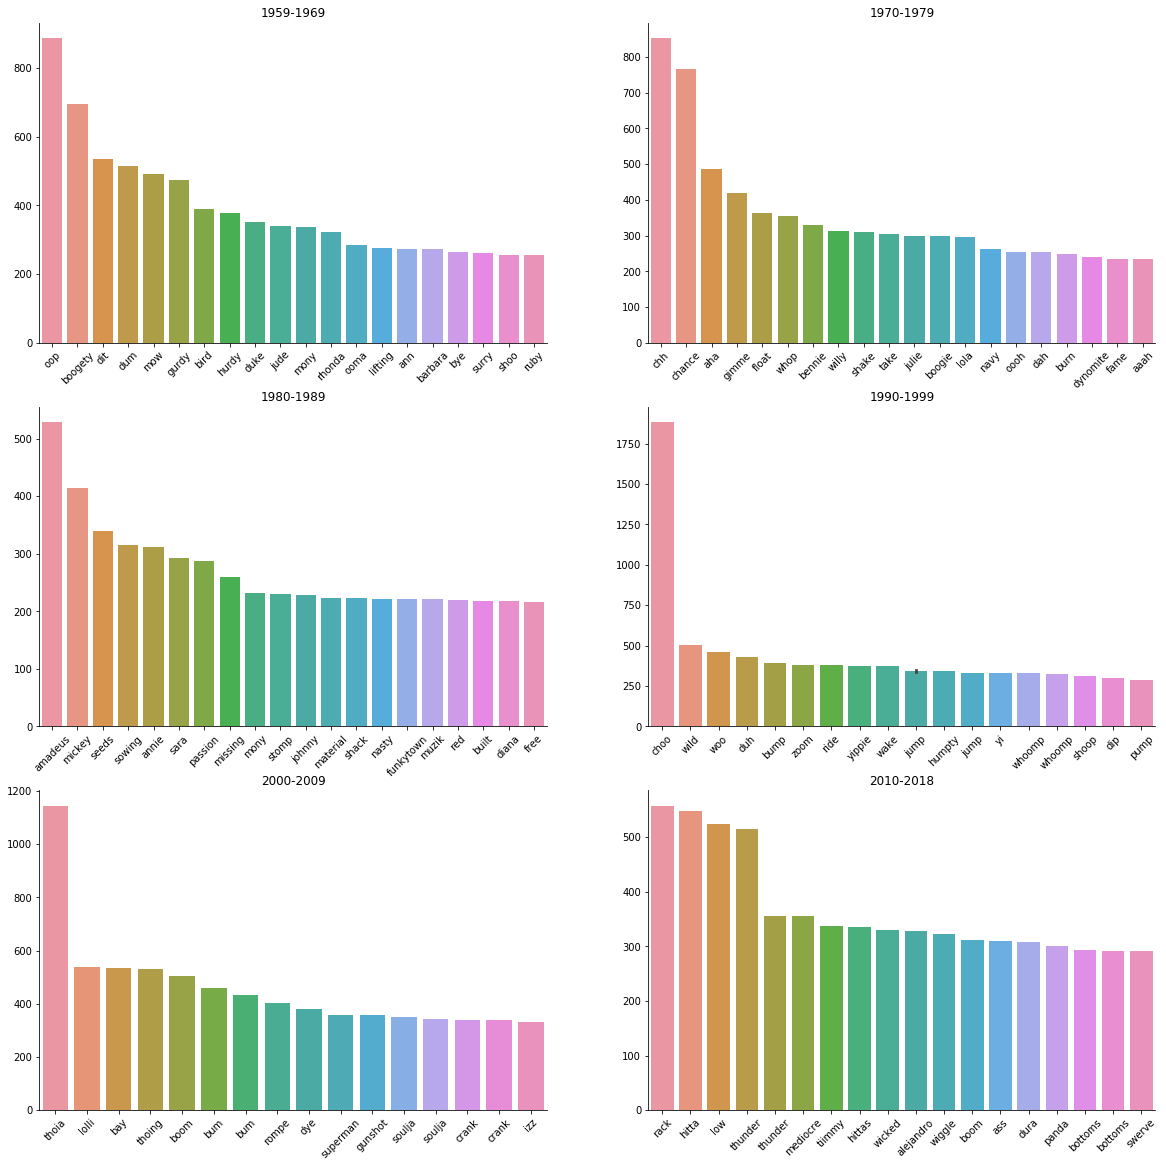

In [79]:
# [plot] top 10 tokens by decade

#dat = tb.select(['decade','token','tfidf','rank']).collect()

#decade = [item[0] for item in dat]
#token = [item[1] for item in dat]
#tfidf = [item[2] for item in dat]
#rank = [item[3] for item in dat]

#tfidf_byDecade = {"decade": decade, "token": token, 
                  #"tfidf": tfidf, "rank": rank}
#DT = pd.DataFrame(tfidf_byDecade)
#DT = DT.sort_values(by = 'decade')

#g = sns.catplot(data = DT, x='rank', y='tfidf', sharex=False, sharey=False,
                #col='decade', col_wrap=2, kind='bar', height=2.5, 
                #aspect=4)

decade_list = tuple(['1959-1969','1970-1979','1980-1989','1990-1999','2000-2009','2010-2018'])

f, axes = plt.subplots(figsize=(20,20),nrows=3,ncols=2)
sns.despine()
axes = axes.flatten()

counter = 0

for item in decade_list:
    dat = tb.select(['decade','token','tfidf','rank']).filter(tb['decade']==item).collect()
    token = [item[1] for item in dat]
    tfidf = [item[2] for item in dat]
    g = sns.barplot(x=token,y=tfidf,ax=axes[counter])
    axes[counter].set_xticklabels(labels=token,rotation=45)
    axes[counter].set_title(item['decade'])
    counter += 1

plt.show()

In [81]:
# [stat.] TF-IDF by genre

TMPALL0 = new.select(['genre','obsnum'])
TMPALL0.createOrReplaceTempView('TMPALL0')

TMPALL1 = spark.sql("SELECT TMPALL0.obsnum, TMPALL0.genre, \
            TFIDF2.token, TFIDF2.tfidf \
            FROM TMPALL0 \
            LEFT JOIN TFIDF2 on TMPALL0.obsnum = TFIDF2.doc_id")
TMPALL1.show()

+------+-------+-------+---------+
|obsnum|  genre|  token|    tfidf|
+------+-------+-------+---------+
|   463|country|   luck|4.5217886|
|   463|country|   lose| 5.278115|
|   463|country|   hand|2.1972246|
|   463|country|    saw|5.7807436|
|   463|country|wedding|15.168737|
|   463|country|   ring|10.397207|
|   463|country|    eye|6.7345915|
|   463|country|   jack| 18.17318|
|   463|country|  night|1.0986123|
|   463|country|   king|26.646637|
|   463|country| regret|4.7361984|
|   463|country| played|15.567281|
|   463|country|thought|4.6051702|
|   463|country|    ace|18.307676|
|   463|country|  cards|4.6728287|
|   463|country|   make|0.6931472|
|   463|country|stacked|6.3902407|
|   463|country|   away|1.3862944|
|   463|country|   made|3.8918202|
|   463|country|   lady|3.1354942|
+------+-------+-------+---------+
only showing top 20 rows



In [86]:
genre_list = ['hip_hop','electronic','rhythm_and_blues','pop','country','rock']

#def test_in(x):
    #return x == genre_list

#f = udf(test_in, BooleanType())
tmp = TMPALL1.select(['genre','token','tfidf']) #.where(f(TMPALL1.genre))
col_list = ['genre']
window = Window.partitionBy([col(x) for x in col_list]).orderBy(tmp['tfidf'].desc())

tb = tmp.select('*',rank().over(window).alias('rank')).filter(col('rank') <= 20)
tb.show()

+-----+---------+----------+----+
|genre|    token|     tfidf|rank|
+-----+---------+----------+----+
| folk|    gurdy|  473.7038|   1|
| folk|    hurdy| 378.96304|   2|
| folk|  rumours| 232.17177|   3|
| folk|   rumour| 230.28105|   4|
| folk|  stuntin| 223.63948|   5|
| folk|submarine| 194.45174|   6|
| folk|  wolfman| 157.90128|   7|
| folk|    wants| 145.56091|   8|
| folk|      ray| 135.10655|   9|
| folk|   georgy| 134.21608|  10|
| folk|    habit| 127.91087|  11|
| folk|  crooked|125.682686|  12|
| folk|     sail| 124.41834|  13|
| folk|   yellow| 119.30869|  14|
| folk|    miami|118.051476|  15|
| folk|    chevy|  104.4462|  16|
| folk|    alvin|  97.36236|  17|
| folk|      hoo|  95.63142|  18|
| folk|     ooga|  94.74076|  19|
| folk|      try|  93.57487|  20|
+-----+---------+----------+----+
only showing top 20 rows



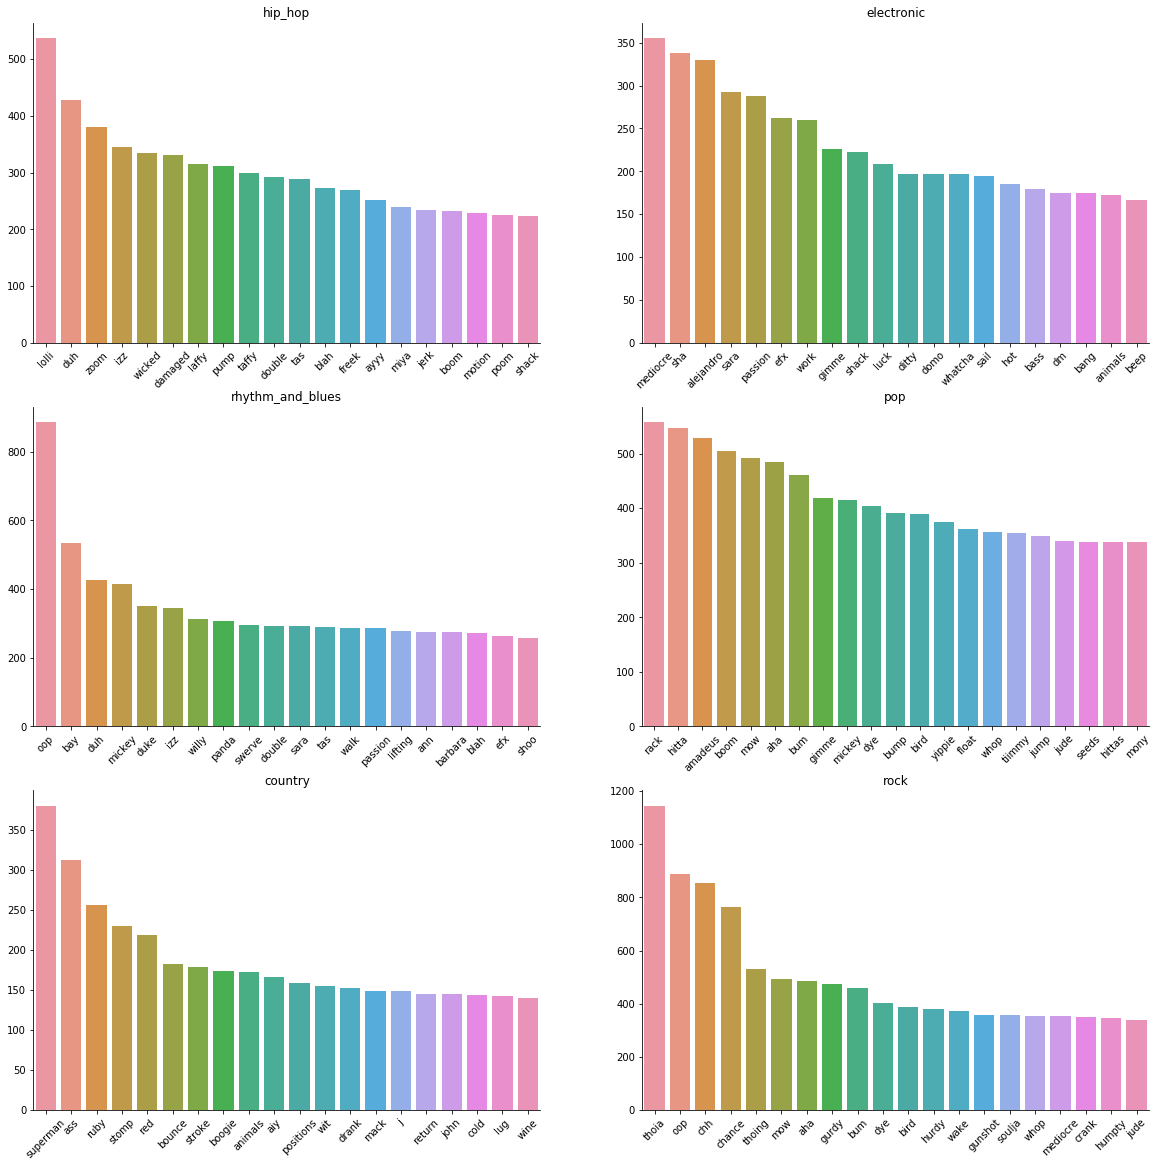

In [87]:
# [plot] top 10 tokens by genre

genre_list = tuple(genre_list)

f, axes = plt.subplots(figsize=(20,20),nrows=3,ncols=2)
sns.despine()
axes = axes.flatten()

counter = 0

for item in genre_list:
    dat = tb.select(['genre','token','tfidf','rank']).filter(tb['genre']==item).collect()
    token = [item[1] for item in dat]
    tfidf = [item[2] for item in dat]
    g = sns.barplot(x=token,y=tfidf,ax=axes[counter])
    axes[counter].set_xticklabels(labels=token,rotation=45)
    axes[counter].set_title(item['genre'])
    counter += 1

plt.show()

### Part 4: Part of Speech

In [64]:
# get tag (word category)

#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')

get_tag = udf(lambda x: nltk.pos_tag(x)[0][1])
POS = dfv.withColumn('token',explode('filtered')).withColumn('tag',get_tag(col('token')))
POS.select(['token','tag']).show()

+---------+---+
|    token|tag|
+---------+---+
|     took| NN|
|   little| NN|
|     trip| NN|
|    along| DT|
|  colonel|NNS|
|  jackson| NN|
|   mighty| NN|
|mississip| NN|
|     took| NN|
|   little| NN|
|    bacon| VB|
|     took| NN|
|   little| NN|
|    beans| NN|
|   caught| VB|
|   bloody| NN|
|  british| NN|
|     near| RB|
|     town| NN|
|      new| JJ|
+---------+---+
only showing top 20 rows



In [65]:
# documentation for each tag
#nltk.download('tagsets')

#nltk.help.upenn_tagset('JJ') # adjective
nltk.help.upenn_tagset('NN') # noun

NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...


In [66]:
# [stat.] top nouns by decade

tmp = POS.filter(POS['tag'] == 'NN').select(['decade','token']).groupBy(['decade','token']).count().alias('count')
col_list = ['decade']
window = Window.partitionBy([col(x) for x in col_list]).orderBy(tmp['count'].desc())

tb = tmp.select('*',rank().over(window).alias('rank')).filter(col('rank') <= 20)
tb.show()


+---------+------+-----+----+
|   decade| token|count|rank|
+---------+------+-----+----+
|1970-1979|  love| 2974|   1|
|1970-1979|  baby| 1390|   2|
|1970-1979|   got| 1129|   3|
|1970-1979|  know| 1123|   4|
|1970-1979|   get| 1100|   5|
|1970-1979|  like|  956|   6|
|1970-1979|   let|  849|   7|
|1970-1979|  time|  801|   8|
|1970-1979|    go|  694|   9|
|1970-1979|   see|  607|  10|
|1970-1979|  good|  580|  11|
|1970-1979| gonna|  575|  12|
|1970-1979| night|  544|  13|
|1970-1979|  make|  531|  14|
|1970-1979| right|  505|  15|
|1970-1979|  girl|  450|  16|
|1970-1979|little|  445|  17|
|1970-1979|  tell|  427|  18|
|1970-1979|  keep|  390|  19|
|1970-1979|  give|  378|  20|
+---------+------+-----+----+
only showing top 20 rows



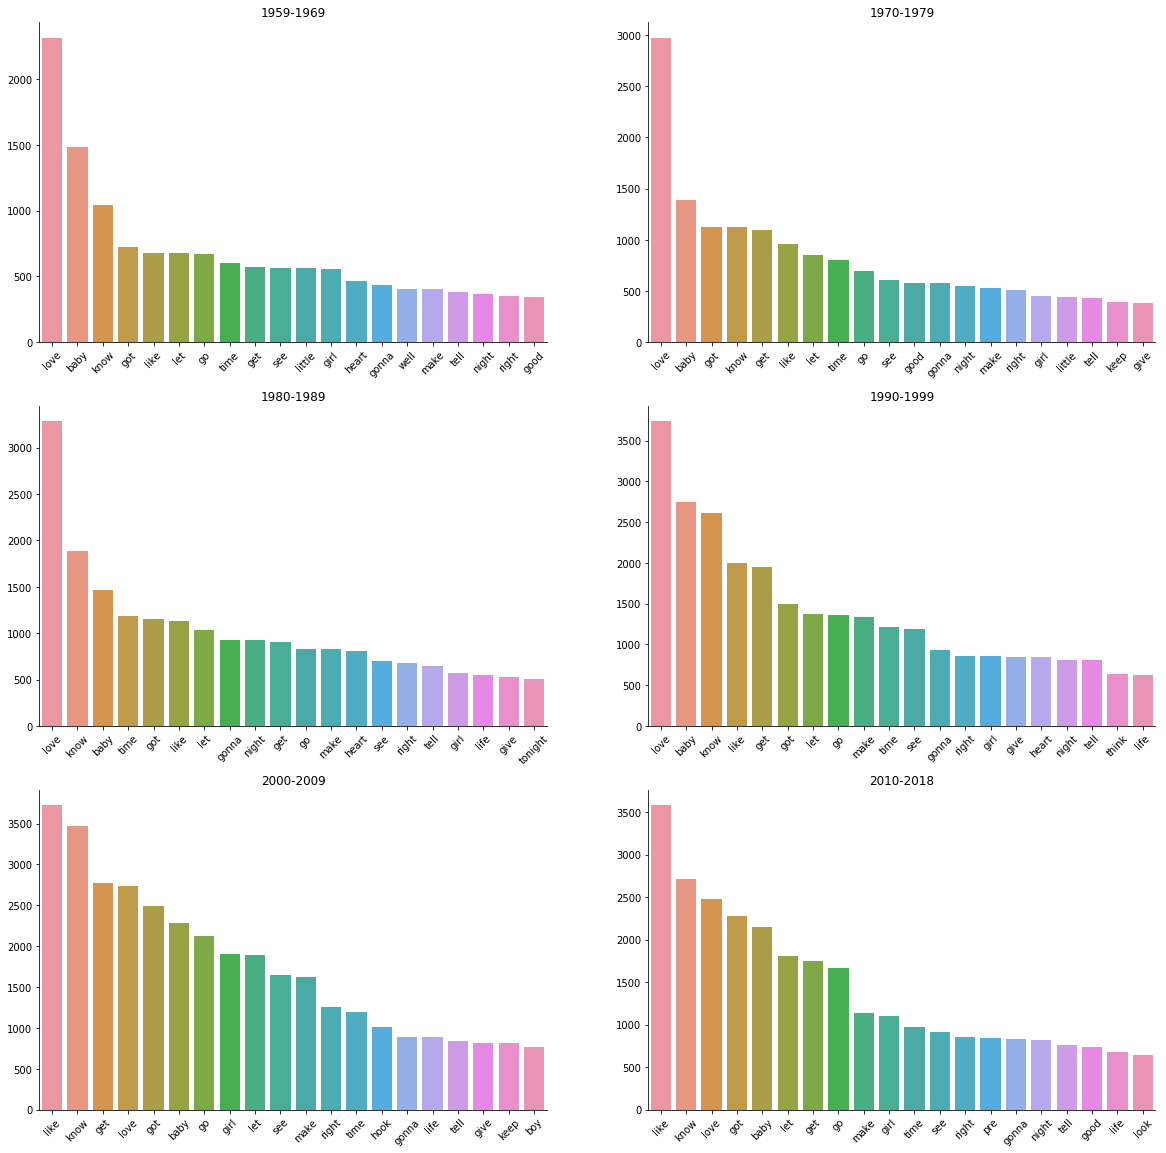

In [67]:
# [plot] top nouns by decade

decade_list = tuple(['1959-1969','1970-1979','1980-1989','1990-1999','2000-2009','2010-2018'])

f, axes = plt.subplots(figsize=(20,20),nrows=3,ncols=2)
sns.despine()
axes = axes.flatten()

counter = 0

for item in decade_list:
    dat = tb.select(['decade','token','count','rank']).filter(tb['decade']==item).collect()
    token = [item[1] for item in dat]
    tfidf = [item[2] for item in dat]
    g = sns.barplot(x=token,y=tfidf,ax=axes[counter])
    axes[counter].set_xticklabels(labels=token,rotation=45)
    axes[counter].set_title(item['decade'])
    counter += 1

plt.show()

In [68]:
# [stat.] top adj by decade

tmp = POS.filter(POS['tag'] == 'JJ').select(['decade','token']).groupBy(['decade','token']).count().alias('count')
col_list = ['decade']
window = Window.partitionBy([col(x) for x in col_list]).orderBy(tmp['count'].desc())

tb = tmp.select('*',rank().over(window).alias('rank')).filter(col('rank') <= 20)
tb.show()

+---------+-------+-----+----+
|   decade|  token|count|rank|
+---------+-------+-----+----+
|1970-1979|    one|  607|   1|
|1970-1979|  never|  558|   2|
|1970-1979|   feel|  448|   3|
|1970-1979|   need|  399|   4|
|1970-1979|  still|  223|   5|
|1970-1979|     us|  222|   6|
|1970-1979|feeling|  201|   7|
|1970-1979|    new|  196|   8|
|1970-1979|  outro|  173|   9|
|1970-1979|    old|  169|  10|
|1970-1979|   free|  166|  11|
|1970-1979|nothing|  140|  12|
|1970-1979|friends|  139|  13|
|1970-1979|  smile|  133|  14|
|1970-1979| friend|  123|  15|
|1970-1979|   oooh|  120|  16|
|1970-1979|   fool|  117|  17|
|1970-1979|  child|  109|  18|
|1970-1979|   used|  107|  19|
|1970-1979| nobody|  103|  20|
+---------+-------+-----+----+
only showing top 20 rows



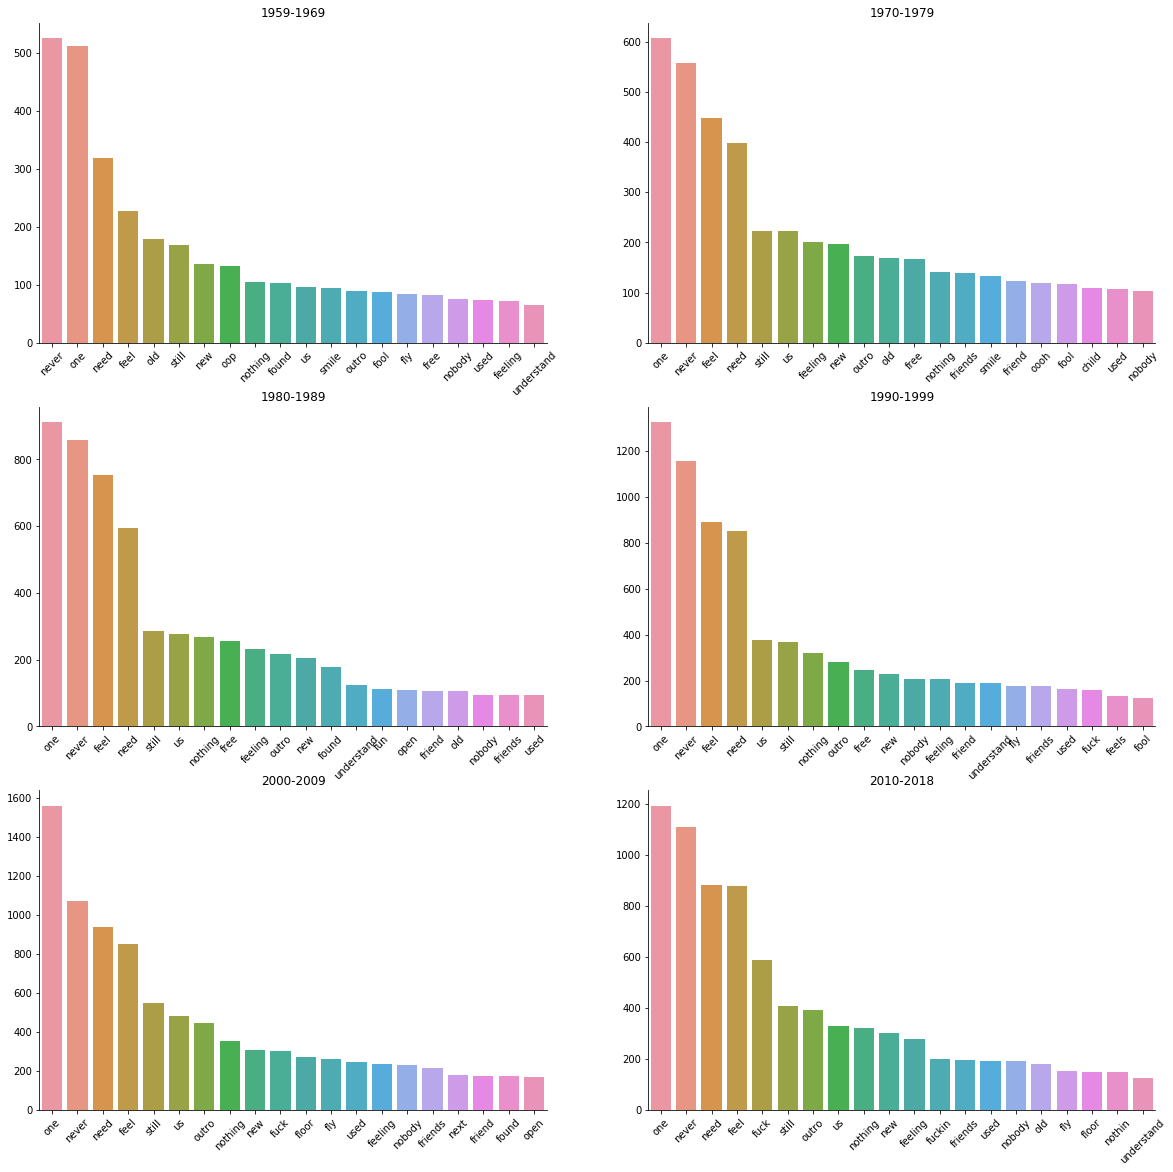

In [69]:
# [plot] top adj by decade

decade_list = tuple(['1959-1969','1970-1979','1980-1989','1990-1999','2000-2009','2010-2018'])

f, axes = plt.subplots(figsize=(20,20),nrows=3,ncols=2)
sns.despine()
axes = axes.flatten()

counter = 0

for item in decade_list:
    dat = tb.select(['decade','token','count','rank']).filter(tb['decade']==item).collect()
    token = [item[1] for item in dat]
    tfidf = [item[2] for item in dat]
    g = sns.barplot(x=token,y=tfidf,ax=axes[counter])
    axes[counter].set_xticklabels(labels=token,rotation=45)
    axes[counter].set_title(item['decade'])
    counter += 1

plt.show()

### Part 5: Word Cloud

(-0.5, 399.5, 199.5, -0.5)

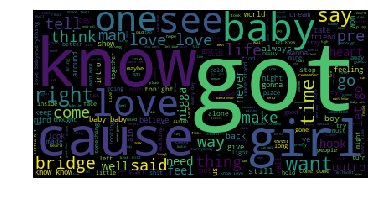

In [70]:
words = " ".join(dfv.select("cleanLyrics").rdd.map(lambda r: r.cleanLyrics).collect())
wordcloud = WordCloud(max_words=2000).generate(words)
plt.imshow(wordcloud)
plt.axis("off")

### Part 6: Word2Vec Embedding

In [71]:
# get the lyrics of number 1 song for year 2017: shape of you

#text = dfv.filter((dfv['rank']==1) & (dfv['year']==2017)).select(['cleanLyrics']).collect()
#text[0].cleanLyrics

text = pdALL[(pdALL['year']==2017) & (pdALL['rank']==1)].iloc[0,7]
text = re.sub('\r|Verse 1|Chorus|Pre-Chorus|Bridge', '', text).replace('[]','')
text = text.split('\n')

# remove empty string from a list
while '' in text:
    text.remove('')

# get word - sentence format for Word2Vec
sentences = []
for item in text:
    sentences.append(item.split(' '))
    
#sentences

In [72]:
# train the model
model = Word2Vec(sentences,min_count=1)

# get summary of the model
#print(model)

# summarize vocabulary
words = list(model.wv.vocab)
#print(words)

# access vector for one word
print(model.wv['place'])

# save model
model.save('model.bin')

# load model
new_model = Word2Vec.load('model.bin')

[ 3.8897148e-03 -4.8180907e-03 -3.8966625e-03  2.3173299e-03
  3.3594491e-03 -5.6530425e-04 -3.4454810e-03 -2.2653835e-03
 -5.3254782e-05  4.7503463e-03 -3.2684086e-03  1.9363888e-03
  3.9430195e-03 -2.9022791e-03 -1.6250391e-03 -2.1713455e-03
 -9.3069696e-04 -3.0366641e-03  4.4943718e-03 -2.7914136e-03
  4.7819996e-03  8.3438109e-04  4.9684788e-03 -6.6796859e-04
  1.2709277e-05 -1.3762980e-03 -4.6584350e-03 -4.5181578e-03
 -3.7180930e-03 -4.6848403e-03 -8.6811342e-05 -4.6997340e-03
  2.3103686e-04 -3.3472569e-04  2.6021989e-03 -4.6530641e-03
  2.5651355e-03  2.8191891e-03  2.4268837e-03 -4.6379799e-03
 -2.7824768e-03 -2.9195045e-05 -6.8146794e-04 -3.5868965e-03
  4.8712916e-03  2.5234688e-03  2.5568521e-03  5.0355643e-03
 -4.2634262e-03 -1.4717730e-03 -3.5829872e-03 -3.0933544e-03
  4.7093385e-04  4.7356756e-03  1.6704502e-03  3.5850478e-03
 -4.2227046e-03  3.0716795e-03  2.3460973e-03  4.3332521e-03
  9.1540447e-04 -1.8467481e-03  6.8226544e-04 -5.8668960e-05
 -3.6267978e-03 -4.17385

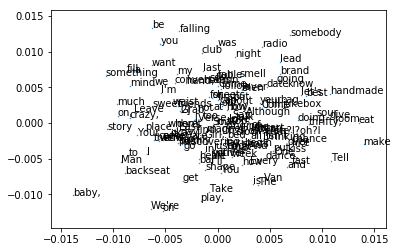

In [73]:
# [plot] plot word vectors using PCA

from sklearn.decomposition import PCA
from matplotlib import pyplot

X = model.wv[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# create a scatter plot of the projection
#fig, ax = plt.subplots(1, 1)

pyplot.scatter(result[:, 0], result[:, 1], s=0.2)
words = list(model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
    
#ax.set_xlim=(0,20)
#ax.set_ylim=(0,20)
pyplot.show()


### Part 7: K Means Clustering

In [42]:
#scaler = StandardScaler(inputCol='features_new',outputCol='scaledFeatures')
#scaler_model = scaler.fit(final_data)
#cluster_final_data = scaler.transform(final_data)
#kmeans2 = KMeans(featuresCol='scaledFeatures',k=2)

final_data = new.select('features_new').withColumnRenamed('features_new','features').dropDuplicates()
kmeans = KMeans().setK(10).setSeed(1) # chose 10: 10 - 20 genre categories
model = kmeans.fit(final_data)

In [43]:
# within set sum of squared errors (WSSSE) - large, consider other unsupervised ML algorithms...
wssse = model.computeCost(final_data)
print(wssse)

60869692.7712


In [44]:
centers = model.clusterCenters()
print(centers)

[array([   0.        ,    0.        ,    0.        , ...,    0.        ,
          0.        , 1209.80216802]), array([   0.        ,    0.        ,    0.        , ...,    0.        ,
          0.        , 1852.27394636]), array([   0.        ,    0.        ,    0.        , ...,    0.        ,
          0.        , 3332.90607735]), array([   0.        ,    0.        ,    0.        , ...,    0.        ,
          0.        , 2769.05078125]), array([  0.        ,   0.        ,   0.        , ...,   0.        ,
         0.        , 909.16346154]), array([   0.        ,    0.        ,    0.        , ...,    0.        ,
          0.        , 1511.64563758]), array([  0.        ,   0.        ,   0.        , ...,   0.        ,
         0.        , 589.26685393]), array([   0.        ,    0.        ,    0.        , ...,    0.        ,
          0.        , 5100.67857143]), array([   0.        ,    0.        ,    0.        , ...,    0.        ,
          0.        , 2253.54810496]), array([   0.

In [48]:
results = model.transform(final_data).groupBy('prediction').count()
results.show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  522|
|         6|  358|
|         3|  256|
|         5|  743|
|         9|  100|
|         4|  729|
|         8|  343|
|         7|   28|
|         2|  181|
|         0|  737|
+----------+-----+



# Source

<1> http://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.XHF5zoWIYdM
    
<2> https://towardsdatascience.com/natural-language-processing-in-apache-spark-using-nltk-part-1-2-58c68824f660\

<3> https://spark.apache.org/docs/2.2.0/ml-features.html

<4> http://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.XHF5zoWIYdM

<5> https://dataplatform.cloud.ibm.com/analytics/notebooks/976931e2-d28d-42d8-b286-966d02af1656/view?access_token=6f078e9b48e7e29a5f805a81daaba6b426603b59c6261be18c353b04cea5fe1e

<6> https://github.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107

<7> http://positivewordsresearch.com/sentiment-analysis-resources/

<8> https://towardsdatascience.com/the-real-world-as-seen-on-twitter-sentiment-analysis-part-two-3ed2670f927d

<9> http://www.tfidf.com

<10> https://dzone.com/articles/calculating-tf-idf-with-apache-spark

<11> https://medium.com/quick-code/yelp-reviews-sentiment-prediction-via-pyspark-mongodb-aws-emr-8bf0e21f5a92

<12> https://www.nltk.org/book/ch05.html

<13> https://machinelearningmastery.com/develop-word-embeddings-python-gensim/